<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Datos_prueba_3%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

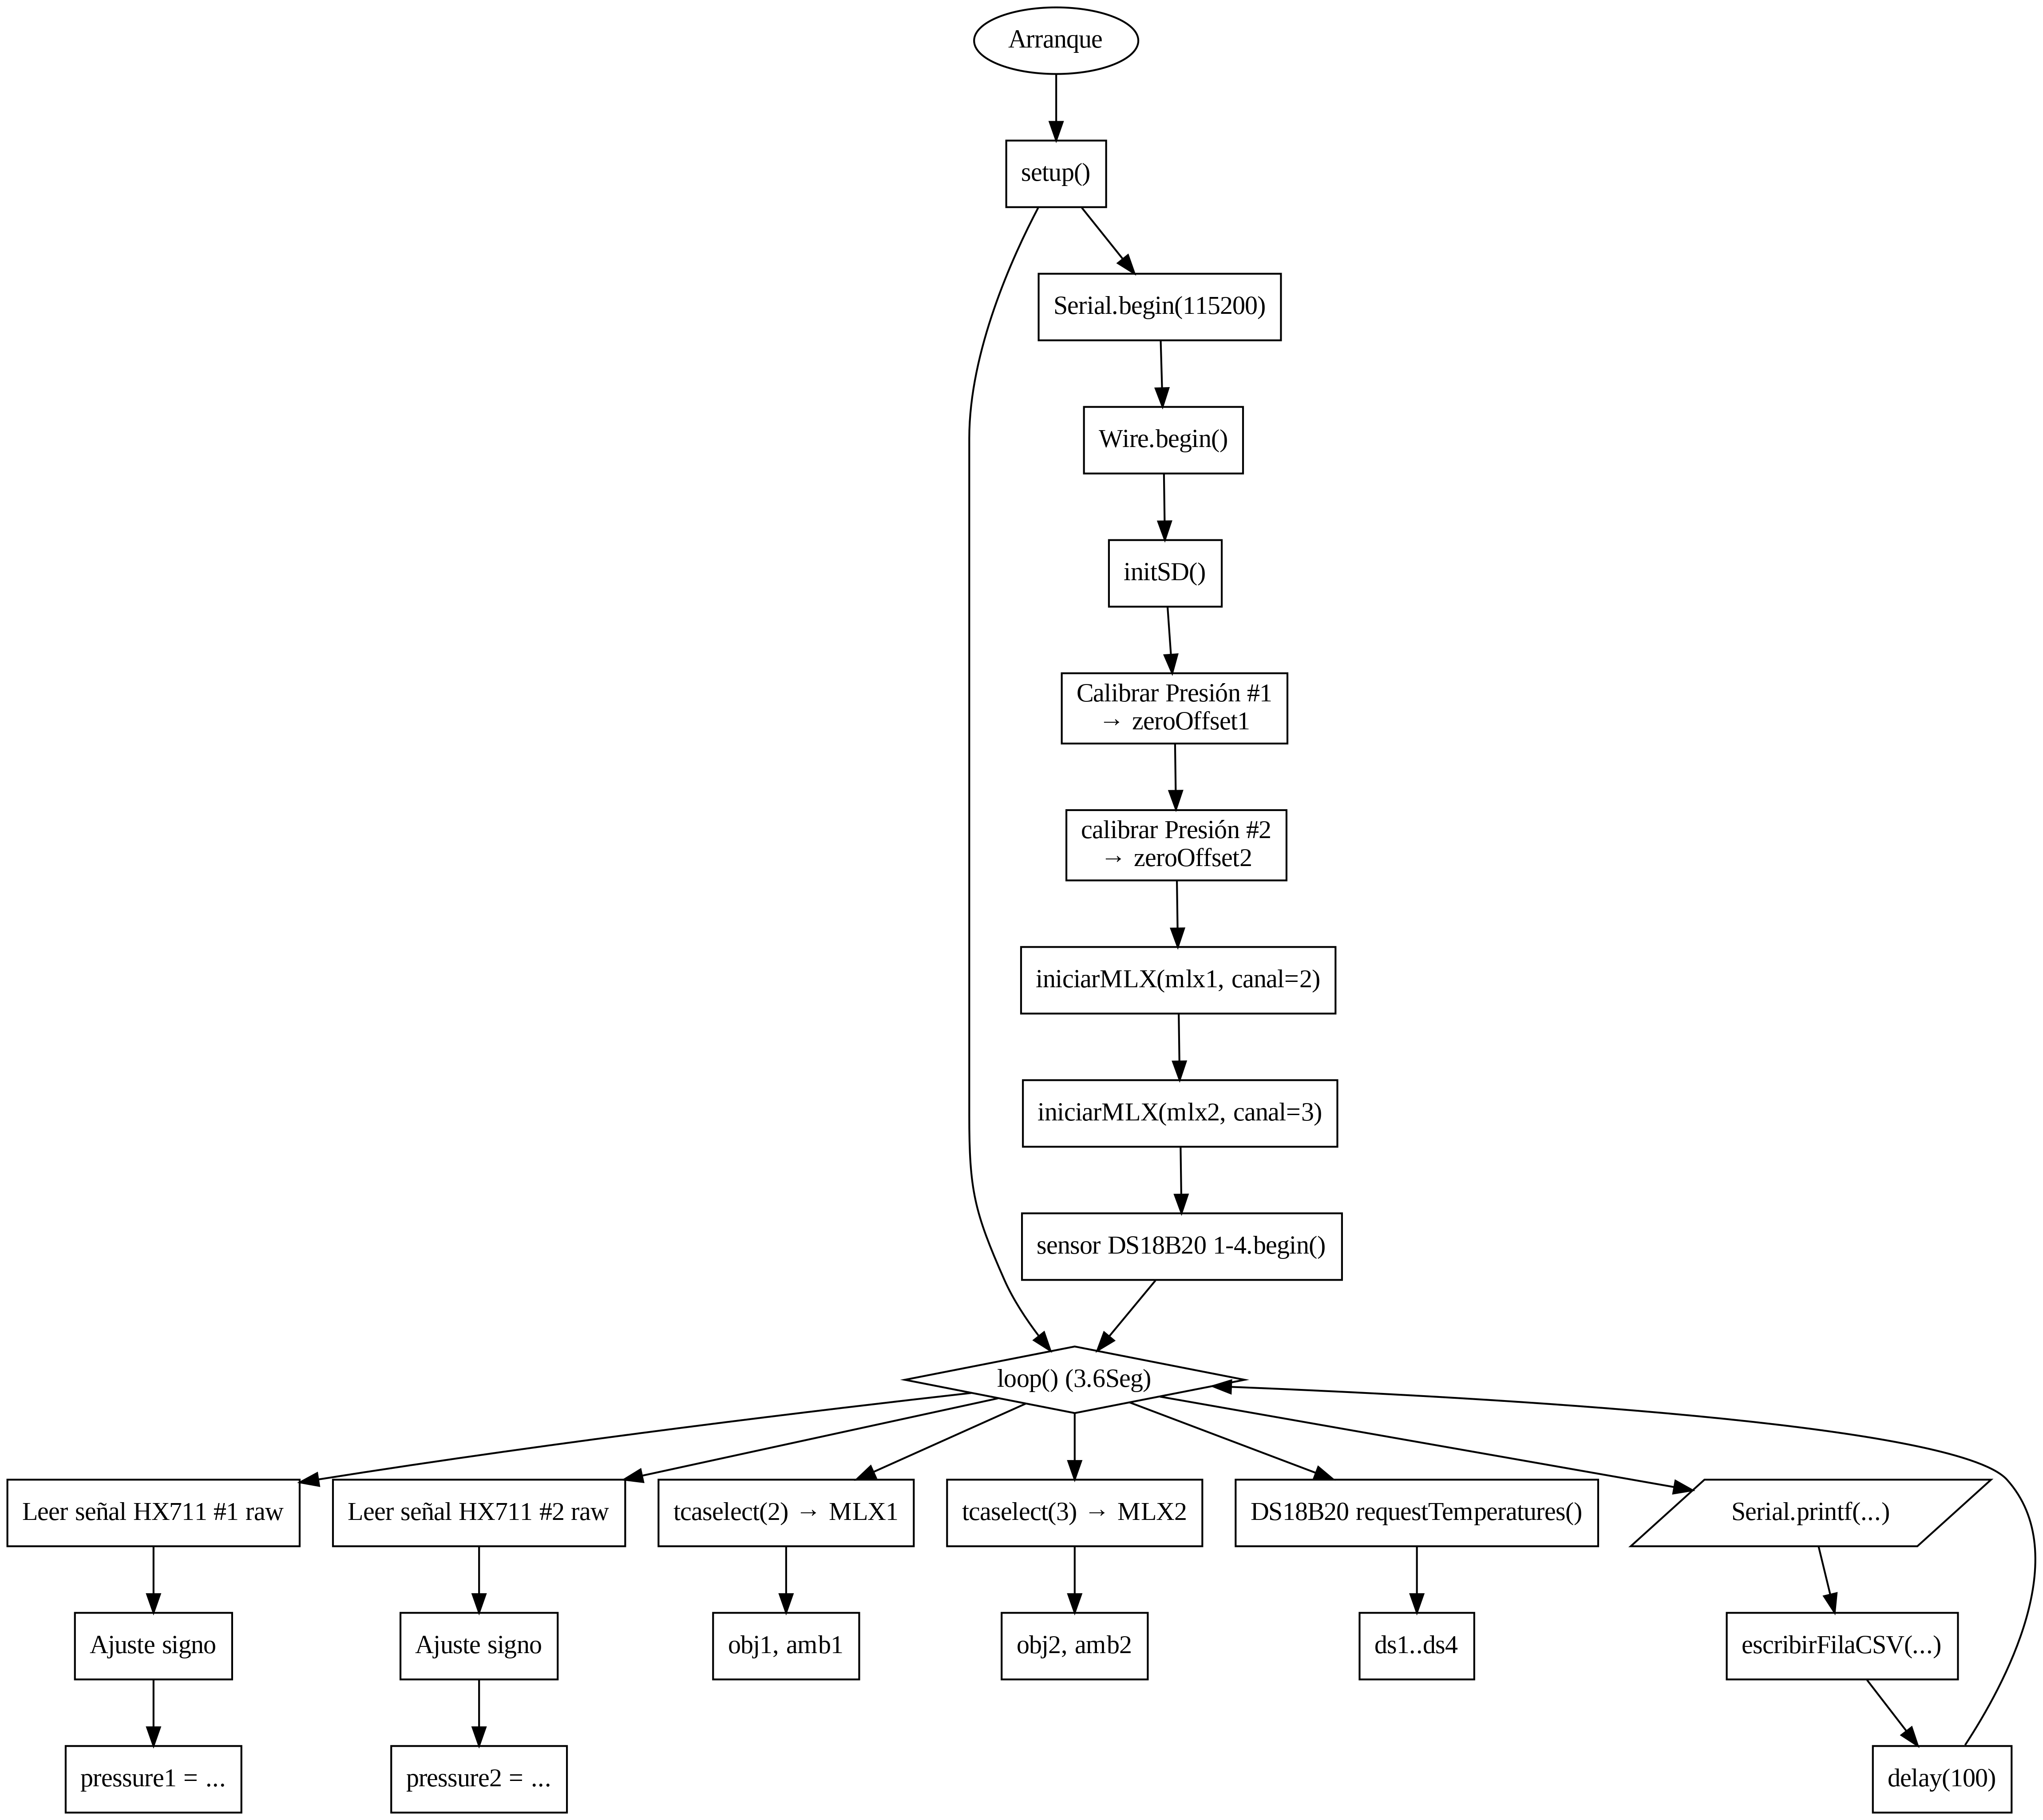

In [1]:
!apt-get -qq install graphviz > /dev/null
!pip install graphviz > /dev/null

from graphviz import Digraph
from IPython.display import Image

dot = Digraph(comment="Diagrama de flujo del logger", format='png')

dot.attr(rankdir='TB')
dot.attr(size='20')
dot.attr(dpi='300')
dot.attr(fontname="Helvetica")

# Nodos principales
dot.node("A", "Arranque", shape="ellipse")
dot.node("B", "setup()", shape="box")
dot.node("C", "loop() (3.6Seg)", shape="diamond")

# Setup
dot.edge("A", "B")
dot.edge("B", "C")
dot.node("B1", "Serial.begin(115200)", shape="box")
dot.node("B2", "Wire.begin()", shape="box")
dot.node("B3", "initSD()", shape="box")
dot.node("B4", "Calibrar Presión #1\n→ zeroOffset1", shape="box")
dot.node("B5", "calibrar Presión #2\n→ zeroOffset2", shape="box")
dot.node("B6", "iniciarMLX(mlx1, canal=2)", shape="box")
dot.node("B7", "iniciarMLX(mlx2, canal=3)", shape="box")
dot.node("B8", "sensor DS18B20 1-4.begin()", shape="box")

dot.edges([("B","B1"),("B1","B2"),("B2","B3"),("B3","B4"),
           ("B4","B5"),("B5","B6"),("B6","B7"),("B7","B8"),("B8","C")])

# Loop interno
dot.node("D1", "Leer señal HX711 #1 raw", shape="box")
dot.node("D2", "Ajuste signo", shape="box")
dot.node("D3", "pressure1 = ...", shape="box")

dot.node("E1", "Leer señal HX711 #2 raw", shape="box")
dot.node("E2", "Ajuste signo", shape="box")
dot.node("E3", "pressure2 = ...", shape="box")

dot.node("F1", "tcaselect(2) → MLX1", shape="box")
dot.node("F2", "obj1, amb1", shape="box")

dot.node("G1", "tcaselect(3) → MLX2", shape="box")
dot.node("G2", "obj2, amb2", shape="box")

dot.node("H1", "DS18B20 requestTemperatures()", shape="box")
dot.node("H2", "ds1..ds4", shape="box")

dot.node("I", "Serial.printf(...)", shape="parallelogram")
dot.node("J", "escribirFilaCSV(...)", shape="box")
dot.node("K", "delay(100)", shape="box")

# Relaciones loop
dot.edges([("C","D1"),("D1","D2"),("D2","D3")])
dot.edges([("C","E1"),("E1","E2"),("E2","E3")])
dot.edges([("C","F1"),("F1","F2")])
dot.edges([("C","G1"),("G1","G2")])
dot.edges([("C","H1"),("H1","H2")])
dot.edge("C","I")
dot.edge("I","J")
dot.edge("J","K")
dot.edge("K","C")

output_path = "diagrama_logger"
dot.render(output_path, format="png", cleanup=True)
Image(filename=output_path + ".png")


In [2]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# === Configura aquí ===
INPUT_PATH  = "serial_log_parte1.csv"
OUTPUT_PATH = "salida1.csv"
CLIP_NEGATIVES = True   # True => si una hora retrocede, dt_s=0 y elapsed no disminuye

# --- Patrones regex ---
TS_RE = re.compile(r'^(?P<ts>\d{2}:\d{2}:\d{2}[.,]\d{3})\s*->\s*(?P<rest>.*)$')

PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)
IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == 'nan' or x == '':
        return float('nan')
    try:
        return float(x)
    except ValueError:
        return float('nan')

def parse_file(text_lines):
    """
    Devuelve una lista de dicts, 1 por bloque.
    Cada bloque se ancla en la línea 'Presiones:' y hereda ese timestamp.
    """
    blocks = []
    cur = None

    def finalize_current():
        nonlocal cur
        if cur is not None:
            blocks.append(cur)
            cur = None

    for raw in text_lines:
        line = raw.rstrip('\n')
        if not line.strip():
            continue

        m = TS_RE.match(line)
        if not m:
            # separador fuera de formato con timestamp
            if SEP_RE.match(line):
                finalize_current()
            continue

        ts = m.group('ts').replace(',', '.')  # normaliza coma decimal si existiera
        rest = m.group('rest')

        # separador con timestamp
        if SEP_RE.match(rest):
            finalize_current()
            continue

        # Inicio de bloque: Presiones
        mp = PRESS_RE.search(rest)
        if mp:
            finalize_current()
            cur = {
                'time': ts,  # se conserva tal cual
                'P1_mmHg': to_float(mp.group(1)),
                'P2_mmHg': to_float(mp.group(2)),
                'IR2_Obj_C': float('nan'),
                'IR2_Amb_C': float('nan'),
                'IR3_Obj_C': float('nan'),
                'IR3_Amb_C': float('nan'),
                'DS_T1_C': float('nan'),
                'DS_T2_C': float('nan'),
                'DS_T3_C': float('nan'),
                'DS_T4_C': float('nan'),
            }
            continue

        # Si no hay bloque iniciado, ignora
        if cur is None:
            continue

        # IR Canal X
        mi = IR_RE.search(rest)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == '2':
                cur['IR2_Obj_C'] = obj
                cur['IR2_Amb_C'] = amb
            elif canal == '3':
                cur['IR3_Obj_C'] = obj
                cur['IR3_Amb_C'] = amb
            continue

        # DS18B20
        md = DS_RE.search(rest)
        if md:
            cur['DS_T1_C'] = to_float(md.group(1))
            cur['DS_T2_C'] = to_float(md.group(2))
            cur['DS_T3_C'] = to_float(md.group(3))
            cur['DS_T4_C'] = to_float(md.group(4))
            continue

    # Fin de archivo
    finalize_current()
    return blocks

def compute_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula dt_s y elapsed_s siguiendo ESTRICTAMENTE el orden del archivo:
      - time: se conserva tal cual (HH:MM:SS.mmm).
      - dt_s: diferencia vs. la fila anterior (en s), sin reordenar ni detectar medianoche.
      - elapsed_s: suma acumulada de dt_s (arranca en 0).
    """
    # Normaliza solo para parseo
    t_str = df['time'].astype(str).str.replace(',', '.', regex=False)

    def hms_to_seconds(hms: str) -> float:
        h, m, s = hms.split(':')
        return int(h)*3600 + int(m)*60 + float(s)

    secs = t_str.apply(hms_to_seconds).to_numpy(dtype=float)

    # Diferencias consecutivas en el ORDEN de las filas
    dt = np.diff(secs, prepend=secs[0])

    # Si alguna marca retrocede y quieres monotonicidad, recorta a 0
    if CLIP_NEGATIVES:
        dt = np.maximum(dt, 0.0)

    elapsed = np.cumsum(dt)
    elapsed[0] = 0.0

    df['elapsed_s'] = elapsed.astype(float)
    df['dt_s'] = dt.astype(float)
    return df

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo de entrada: {p.resolve()}")
    with p.open('r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    blocks = parse_file(lines)
    if not blocks:
        raise RuntimeError("No se pudieron extraer bloques. ¿El formato coincide con los ejemplos?")

    df = pd.DataFrame(blocks, columns=[
        'time','P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ])

    df = compute_times(df)

    # Orden final homogéneo
    cols = [
        'time','elapsed_s','dt_s',
        'P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ]
    df = df[cols]

    df.to_csv(out_path, index=False, encoding='utf-8', float_format='%.3f')
    print(f"Listo. Se escribió el CSV limpio en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


Listo. Se escribió el CSV limpio en: /content/salida1.csv


In [3]:

import re
from pathlib import Path
import pandas as pd
import numpy as np

# === Configura aquí ===
INPUT_PATH  = "serial_log_parte2.csv"   # CSV con: seq, iso_ts, mensaje
OUTPUT_PATH = "salida2.csv"             # CSV limpio de salida

# --- Offsets solicitados ---
OFFSETS = {
    "P1_mmHg": 10.600,
    "P2_mmHg": 174.000,
    "elapsed_s": 24001.140,  # <- clave corregida: elapsed_s
}

# Offset global (todas las numéricas)
GLOBAL_OFFSET = 0.0

# Filtros para aplicar (deja en None si quieres que aplique a TODO)
ROW_INDEX_RANGE = None         # (inicio, fin) por índice, inclusivo. Ej.: (100, 500)
ELAPSED_RANGE_S = None         # (t0, t1) en segundos. Ej.: (30.0, 120.0)
TIME_RANGE_HMS  = None         # ("HH:MM:SS.mmm", "HH:MM:SS.mmm")

# Calcular tiempo: recortar negativos en dt (monotonía)
CLIP_NEGATIVES = True

# --- Patrones ---
PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)
IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == "nan" or x == "":
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

def iso_to_parts(iso_str: str):
    """
    Devuelve:
      - dt (datetime64[ns]) de pandas
      - time_str: 'HH:MM:SS.mmm'
    """
    dt = pd.to_datetime(iso_str, utc=False, errors="raise")
    time_str = dt.strftime("%H:%M:%S.") + f"{int(dt.microsecond/1000):03d}"
    return dt, time_str

def parse_blocks(df_raw: pd.DataFrame) -> list[dict]:
    """
    Recorre el CSV (en el orden del archivo por 'seq') y arma bloques
    anclados a la línea 'Presiones'. Cada bloque hereda su timestamp de esa línea.
    """
    blocks = []
    cur = None

    for _, row in df_raw.sort_values("seq").iterrows():
        msg = str(row["mensaje"]).strip()
        iso = str(row["iso_ts"]).strip()

        # Cierre por separador
        if SEP_RE.match(msg):
            if cur is not None:
                blocks.append(cur)
                cur = None
            continue

        # Inicio de bloque: Presiones
        mp = PRESS_RE.search(msg)
        if mp:
            if cur is not None:
                blocks.append(cur)

            dt, time_str = iso_to_parts(iso)
            cur = {
                "seq": int(row["seq"]) if pd.notna(row["seq"]) else None,
                "time": time_str,  # HH:MM:SS.mmm (se usará para el tiempo)
                "P1_mmHg": to_float(mp.group(1)),
                "P2_mmHg": to_float(mp.group(2)),
                "IR2_Obj_C": np.nan, "IR2_Amb_C": np.nan,
                "IR3_Obj_C": np.nan, "IR3_Amb_C": np.nan,
                "DS_T1_C": np.nan, "DS_T2_C": np.nan, "DS_T3_C": np.nan, "DS_T4_C": np.nan,
            }
            continue

        # Si no hay bloque iniciado, ignora
        if cur is None:
            continue

        # IR
        mi = IR_RE.search(msg)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == "2":
                cur["IR2_Obj_C"] = obj
                cur["IR2_Amb_C"] = amb
            elif canal == "3":
                cur["IR3_Obj_C"] = obj
                cur["IR3_Amb_C"] = amb
            continue

        # DS18B20
        md = DS_RE.search(msg)
        if md:
            cur["DS_T1_C"] = to_float(md.group(1))
            cur["DS_T2_C"] = to_float(md.group(2))
            cur["DS_T3_C"] = to_float(md.group(3))
            cur["DS_T4_C"] = to_float(md.group(4))
            continue

    if cur is not None:
        blocks.append(cur)
    return blocks

def compute_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula dt_s y elapsed_s estrictamente en el ORDEN del archivo:
      - 'time' se conserva tal cual (HH:MM:SS.mmm).
      - dt_s = diferencia vs. fila anterior (en s), sin reordenar ni detectar medianoche.
      - elapsed_s = suma acumulada de dt_s (arranca en 0).
    """
    # Orden por 'seq' si existe (mantenemos orden del archivo)
    if 'seq' in df.columns:
        df = df.sort_values('seq').reset_index(drop=True)

    # Normaliza solo para parseo (NO modifica df['time'])
    t_str = df['time'].astype(str).str.replace(',', '.', regex=False)

    def hms_to_seconds(hms: str) -> float:
        h, m, s = hms.split(':')
        return int(h)*3600 + int(m)*60 + float(s)

    secs = t_str.apply(hms_to_seconds).to_numpy(dtype=float)

    # Diferencias consecutivas
    dt = np.diff(secs, prepend=secs[0])
    if CLIP_NEGATIVES:
        dt = np.maximum(dt, 0.0)

    elapsed = np.cumsum(dt)
    elapsed[0] = 0.0

    df['elapsed_s'] = elapsed.astype(float)
    df['dt_s'] = dt.astype(float)

    # quita 'seq' si no la quieres en salida
    if 'seq' in df.columns:
        df = df.drop(columns=['seq'])

    return df

def _mask_for_corrections(df: pd.DataFrame) -> pd.Series:
    """Máscara booleana para delimitar dónde aplicar las correcciones."""
    mask = pd.Series(True, index=df.index)

    if ROW_INDEX_RANGE is not None:
        i0, i1 = ROW_INDEX_RANGE
        mask &= (df.index >= i0) & (df.index <= i1)

    if ELAPSED_RANGE_S is not None and "elapsed_s" in df.columns:
        e0, e1 = ELAPSED_RANGE_S
        mask &= (df["elapsed_s"] >= e0) & (df["elapsed_s"] <= e1)

    if TIME_RANGE_HMS is not None and "time" in df.columns:
        t0, t1 = TIME_RANGE_HMS
        mask &= (df["time"] >= t0) & (df["time"] <= t1)

    return mask

def apply_corrections(df: pd.DataFrame) -> pd.DataFrame:
    """Aplica offsets por columna y/u offset global según filtros; si cambia elapsed_s, recalcula dt_s."""
    df = df.copy()
    mask = _mask_for_corrections(df)

    changed_elapsed = False

    # Offsets por columna
    for col, delta in OFFSETS.items():
        if col in df.columns and np.isfinite(delta) and float(delta) != 0.0:
            vals = pd.to_numeric(df.loc[mask, col], errors="coerce")
            df.loc[mask, col] = vals + float(delta)
            if col == "elapsed_s":
                changed_elapsed = True

    # Offset global
    if GLOBAL_OFFSET and np.isfinite(GLOBAL_OFFSET):
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        for col in num_cols:
            vals = pd.to_numeric(df.loc[mask, col], errors="coerce")
            df.loc[mask, col] = vals + float(GLOBAL_OFFSET)
            if col == "elapsed_s":
                changed_elapsed = True

    # Si tocamos elapsed_s, recalcular dt_s
    if changed_elapsed and "elapsed_s" in df.columns:
        df["dt_s"] = pd.to_numeric(df["elapsed_s"], errors="coerce").diff().fillna(0.0)

    return df

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {p.resolve()}")

    # Lee 3 columnas: seq, iso_ts, mensaje
    df_raw = pd.read_csv(
        p,
        header=None,
        names=["seq", "iso_ts", "mensaje"],
        dtype={"seq": "Int64", "iso_ts": str, "mensaje": str},
        keep_default_na=False,
        encoding="utf-8",
        engine="python"
    )

    blocks = parse_blocks(df_raw)
    if not blocks:
        raise RuntimeError("No se detectaron bloques con 'Presiones'.")

    df = pd.DataFrame(blocks)

    # Tiempo secuencial por 'time' en el orden del archivo
    df = compute_time_cols(df)

    # Columnas homogéneas
    cols = [
        "time", "elapsed_s", "dt_s",
        "P1_mmHg", "P2_mmHg",
        "IR2_Obj_C", "IR2_Amb_C", "IR3_Obj_C", "IR3_Amb_C",
        "DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"
    ]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    df = df[cols]

    # Aplica tus correcciones (incluye elapsed_s)
    df = apply_corrections(df)

    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"CSV escrito en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


CSV escrito en: /content/salida2.csv


In [4]:
import pandas as pd
from pathlib import Path

# === Configura aquí ===
CSV1 = "salida1.csv"   # primer CSV
CSV2 = "salida2.csv"   # segundo CSV
OUTPUT = "salida_unida.csv"

def unir_csvs(csv1, csv2, out_path=OUTPUT):
    # Cargar ambos
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Tomar solo columnas en común
    common_cols = [c for c in df1.columns if c in df2.columns]
    df1 = df1[common_cols]
    df2 = df2[common_cols]

    # Concatenar tal cual (sin reordenar ni recalcular)
    df = pd.concat([df1, df2], ignore_index=True)

    # Guardar
    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"Archivo combinado guardado en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    unir_csvs(CSV1, CSV2, OUTPUT)

Archivo combinado guardado en: /content/salida_unida.csv


/tmp/ipython-input-3105832059.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start = pd.to_datetime(x_dt.iloc[0]).round('S')


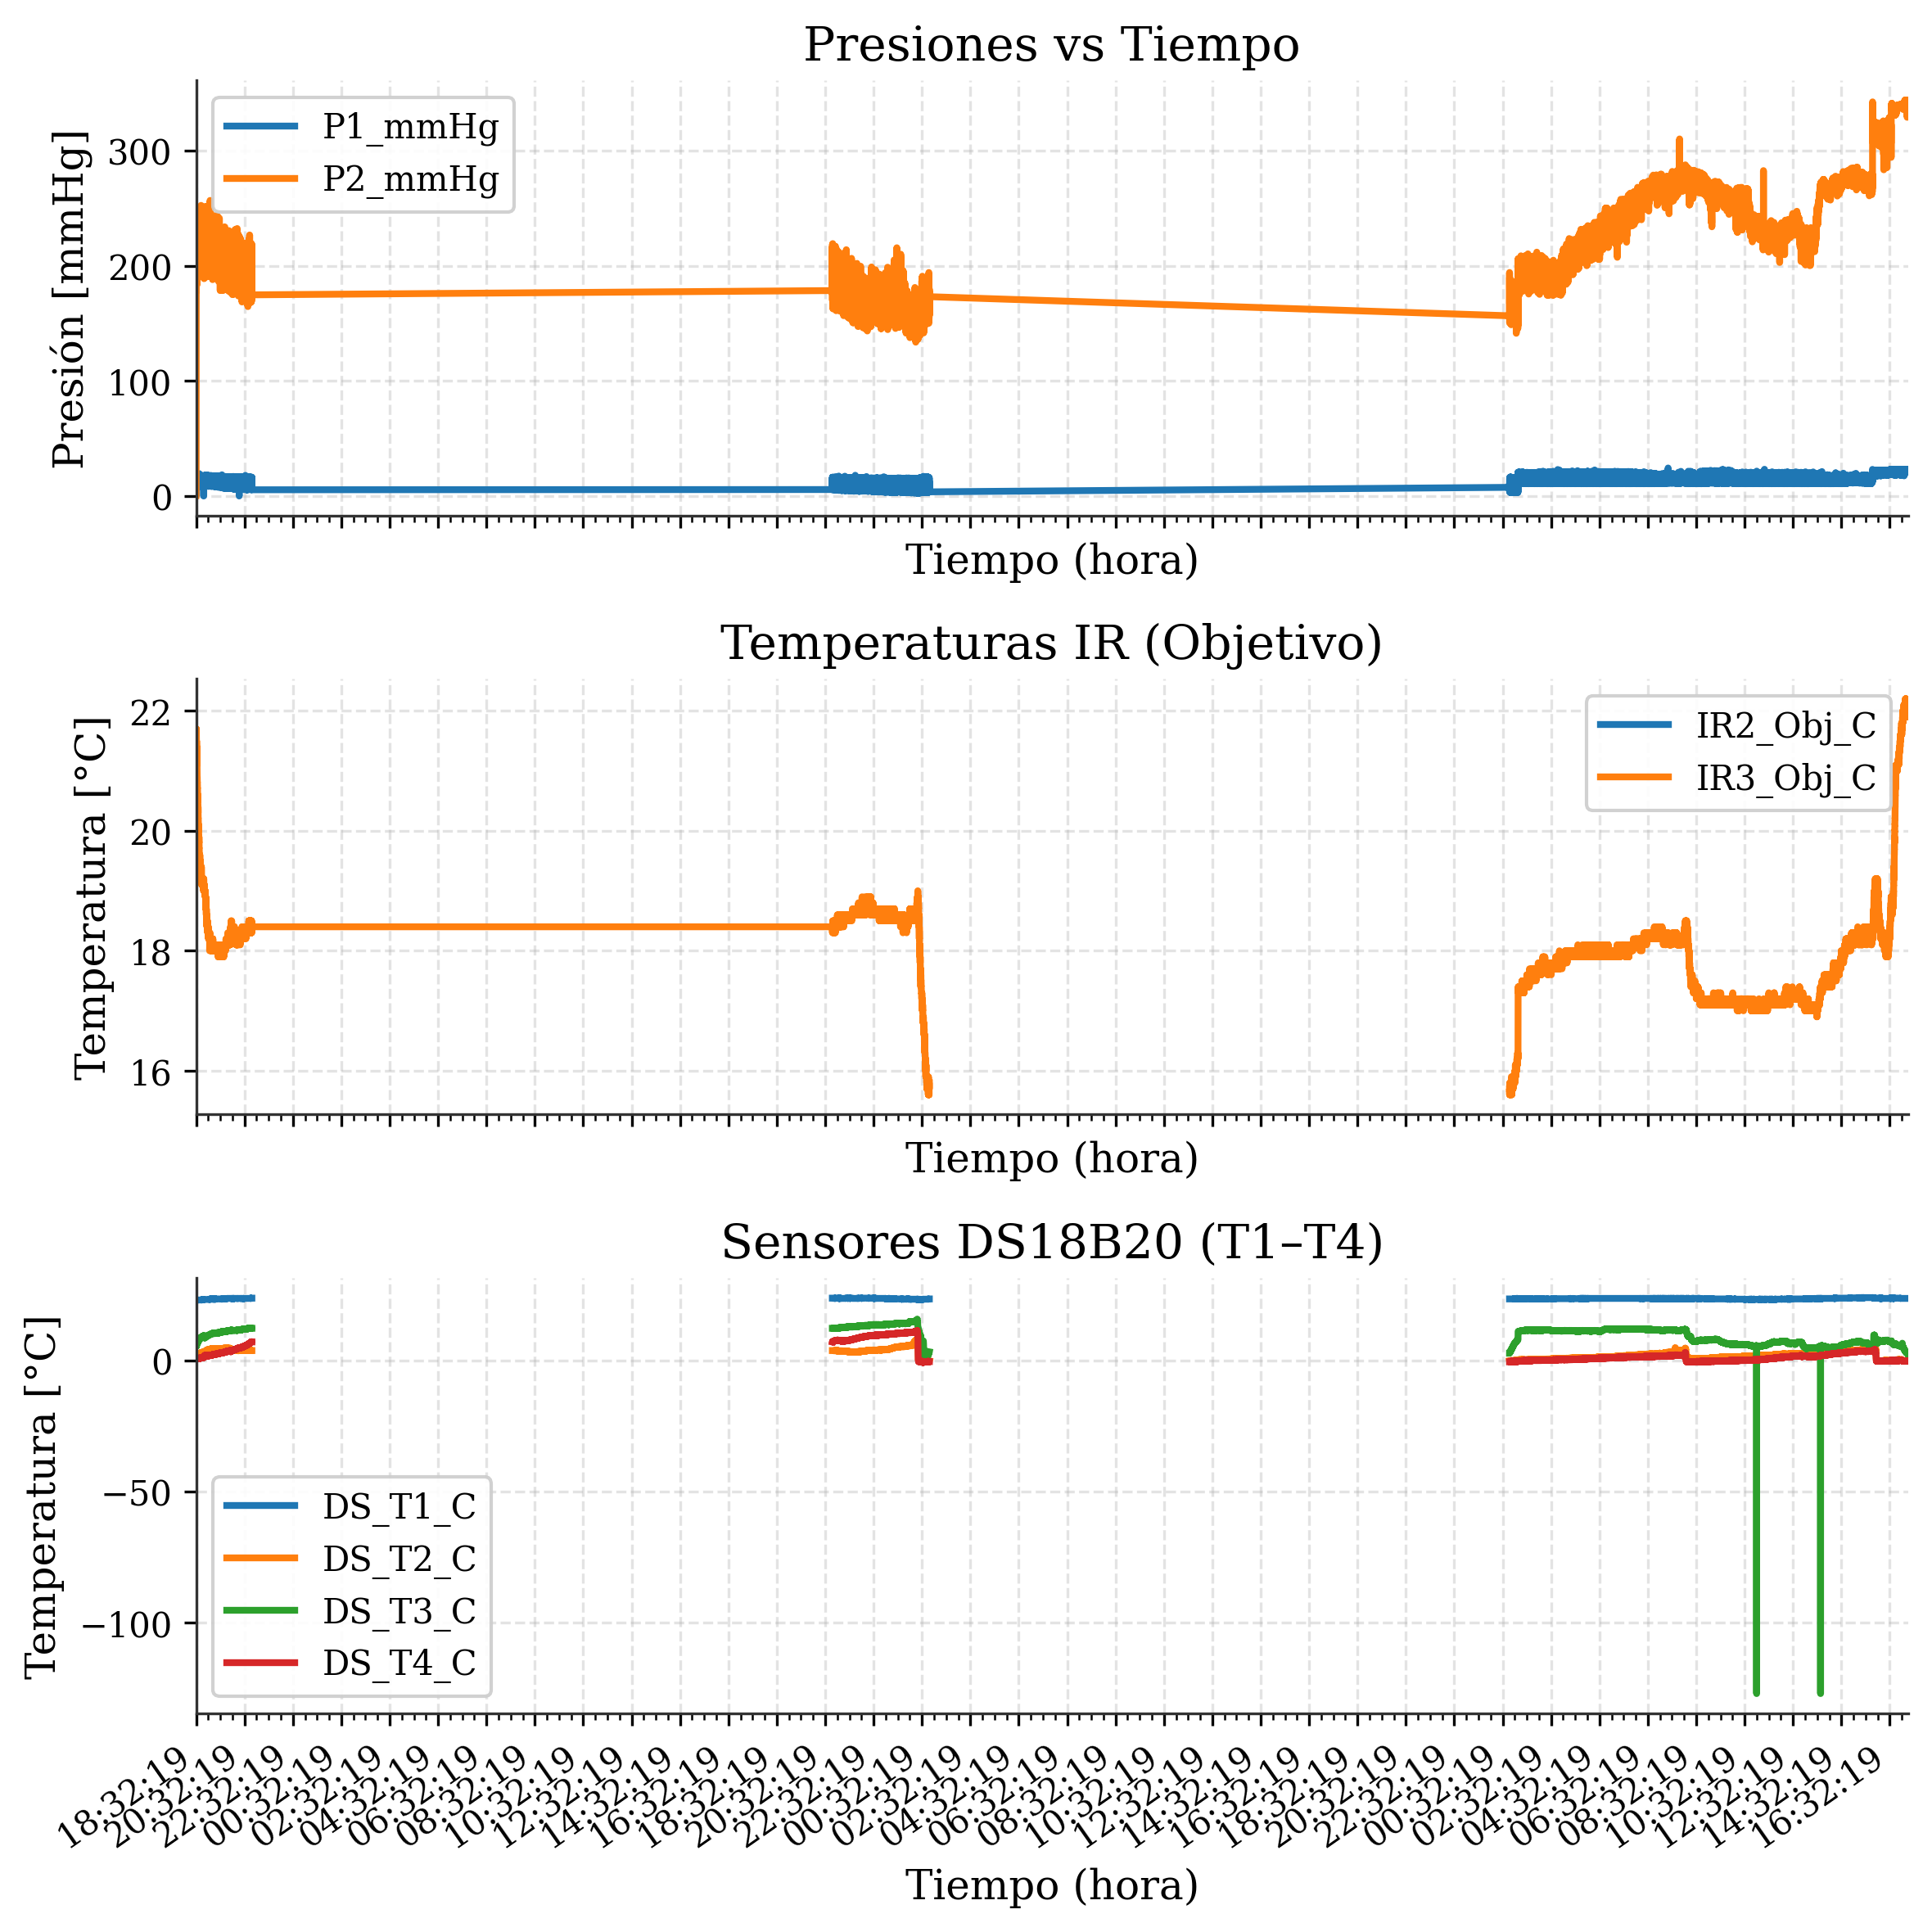

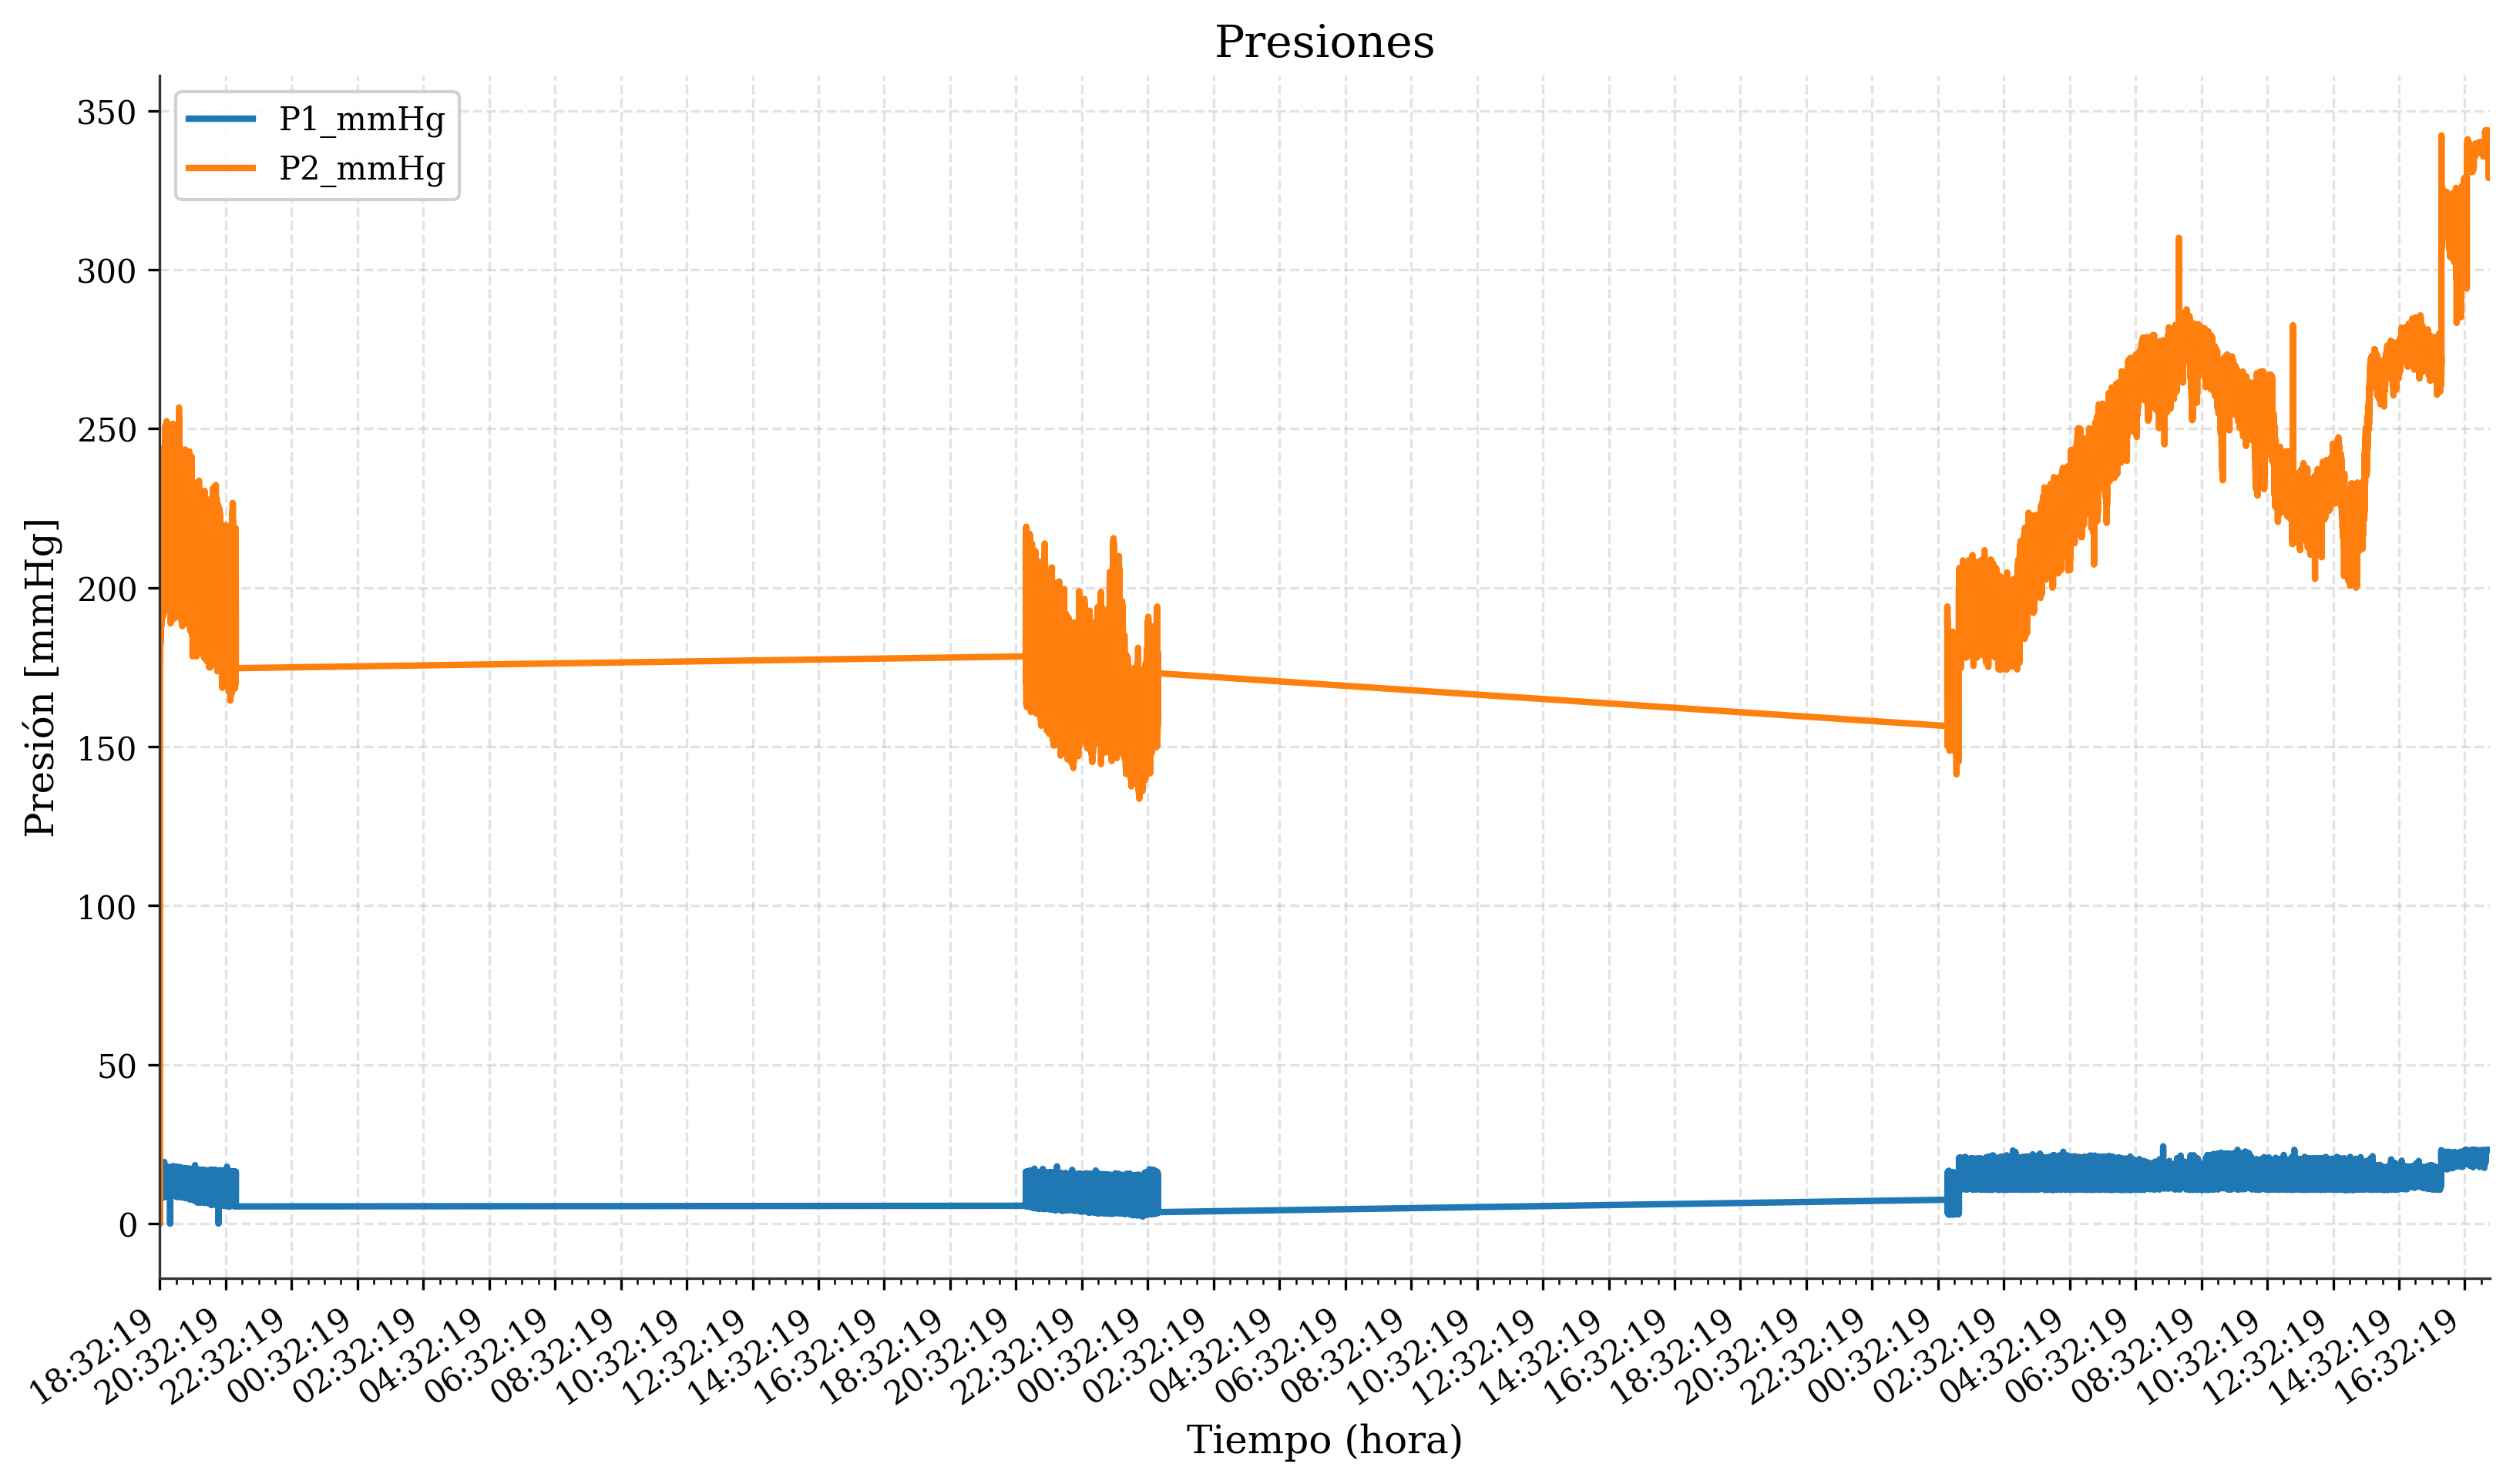

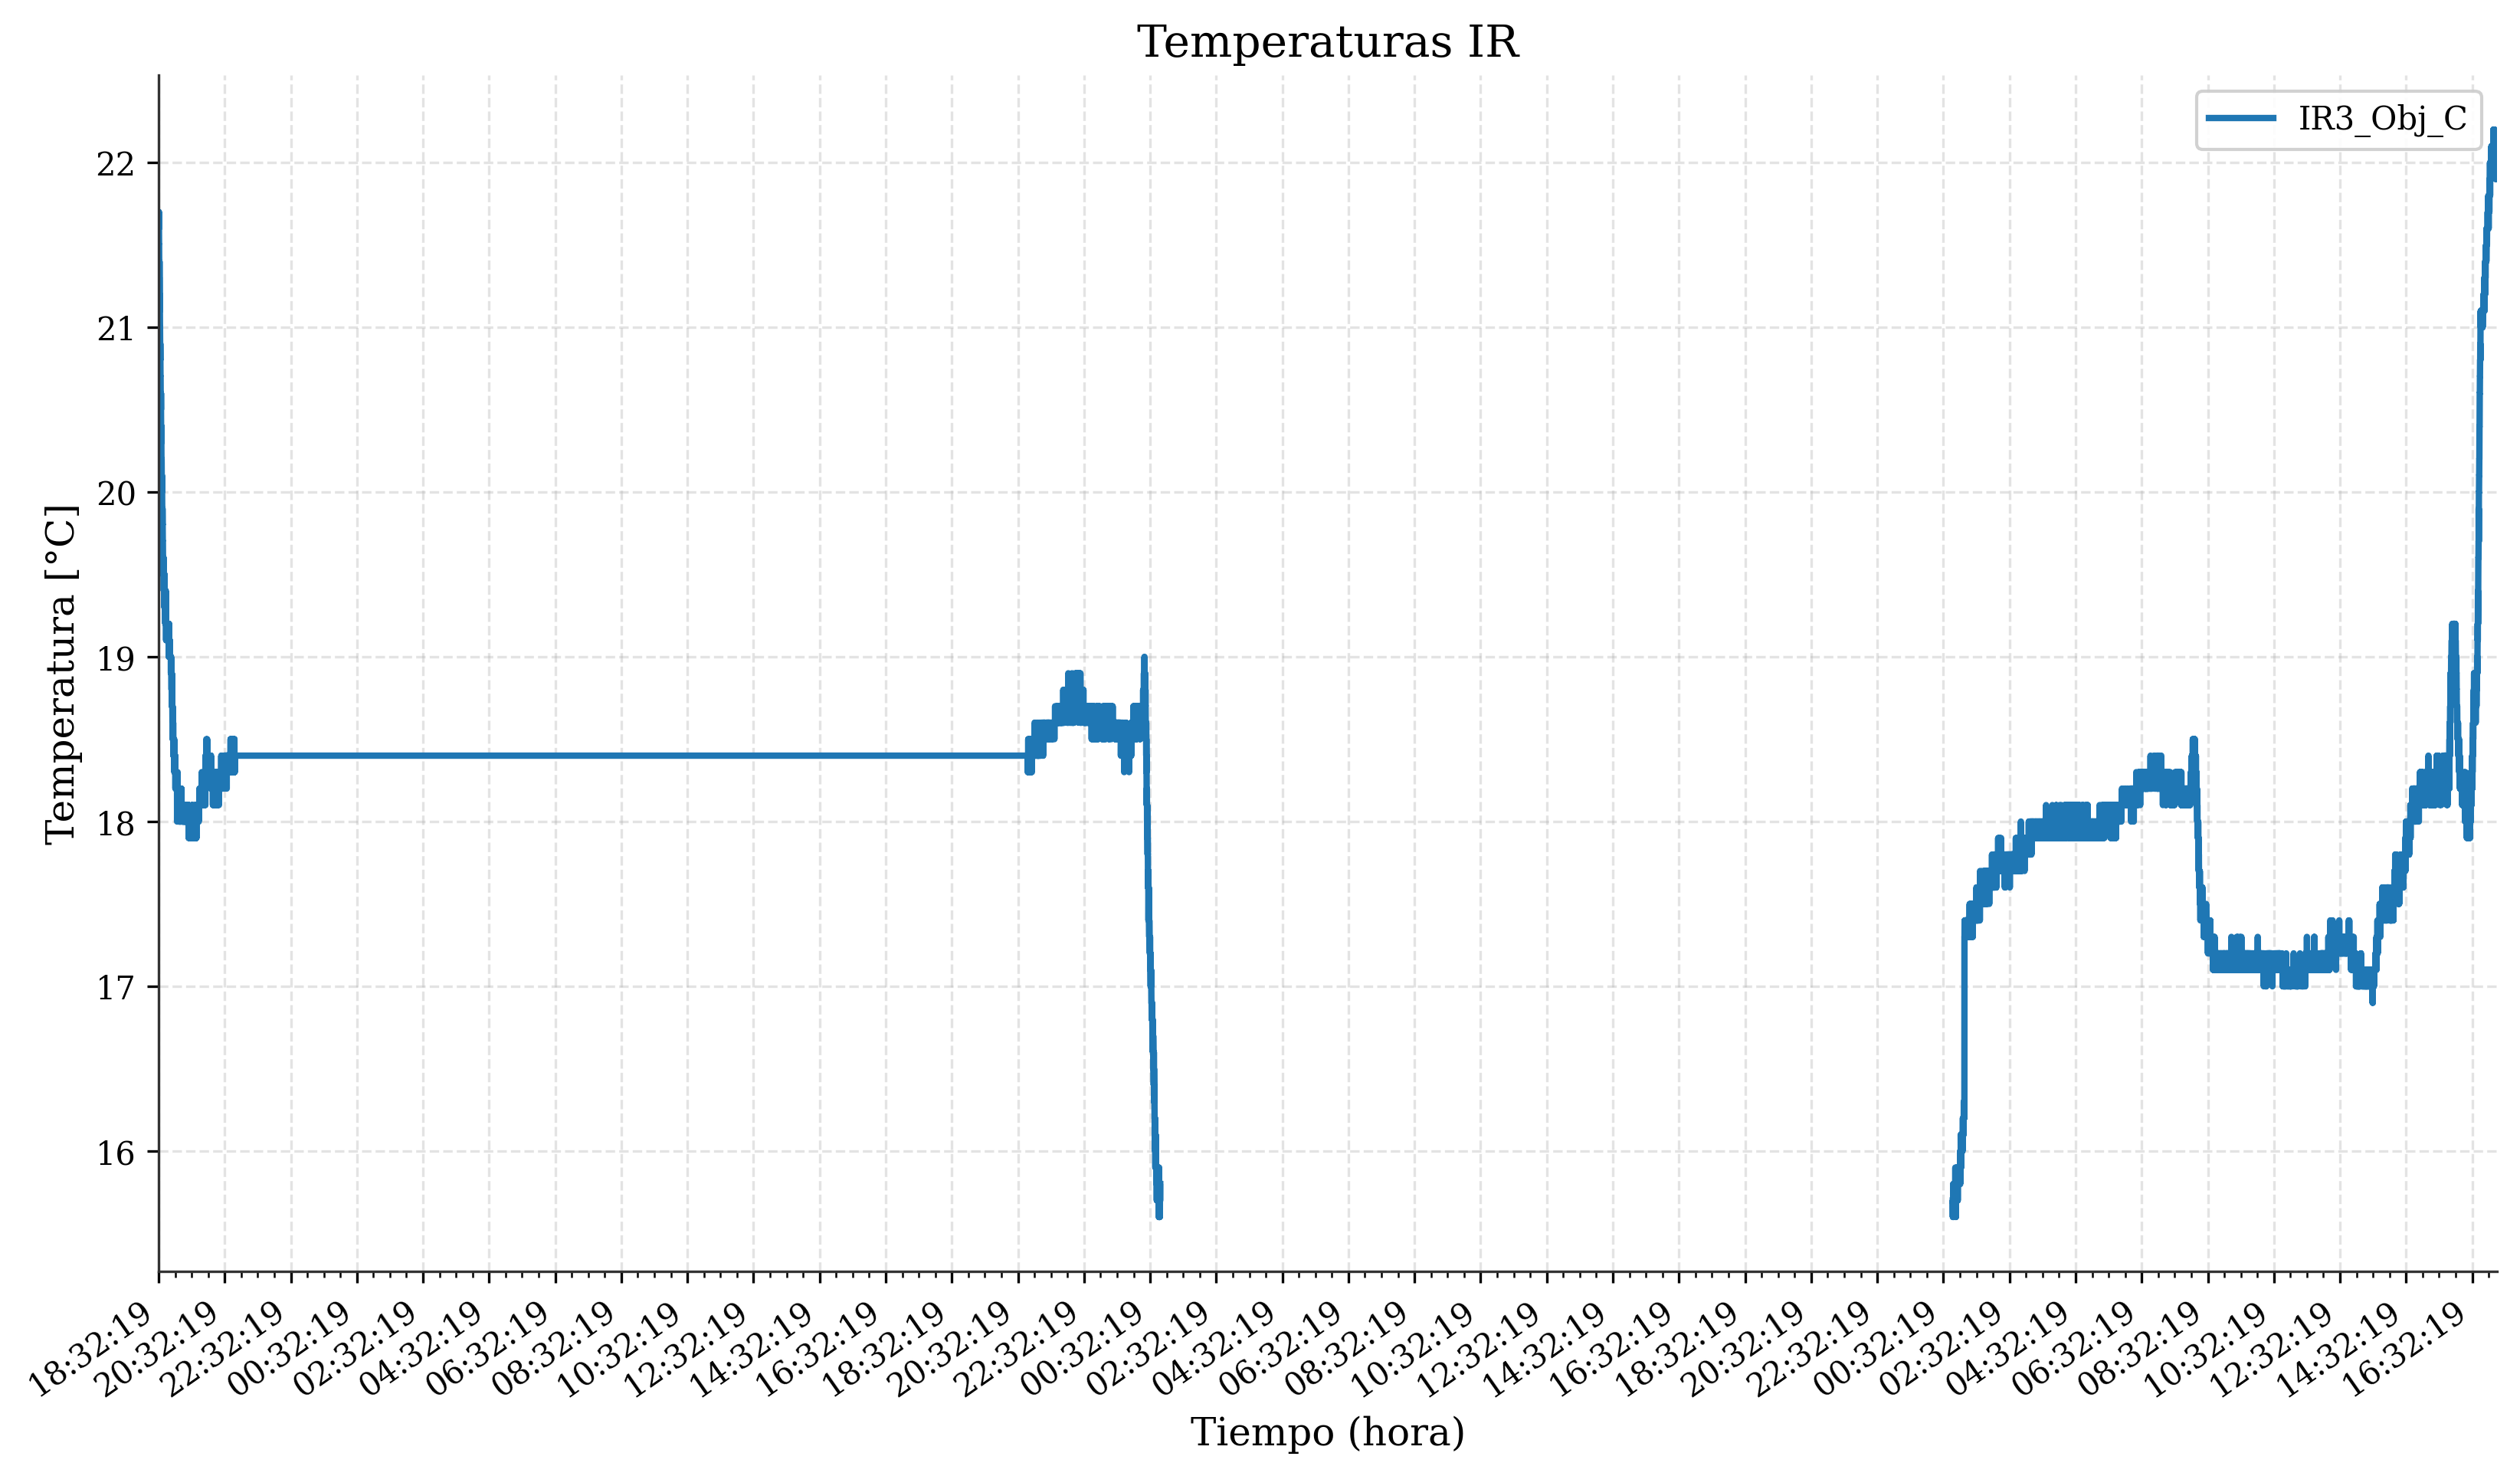

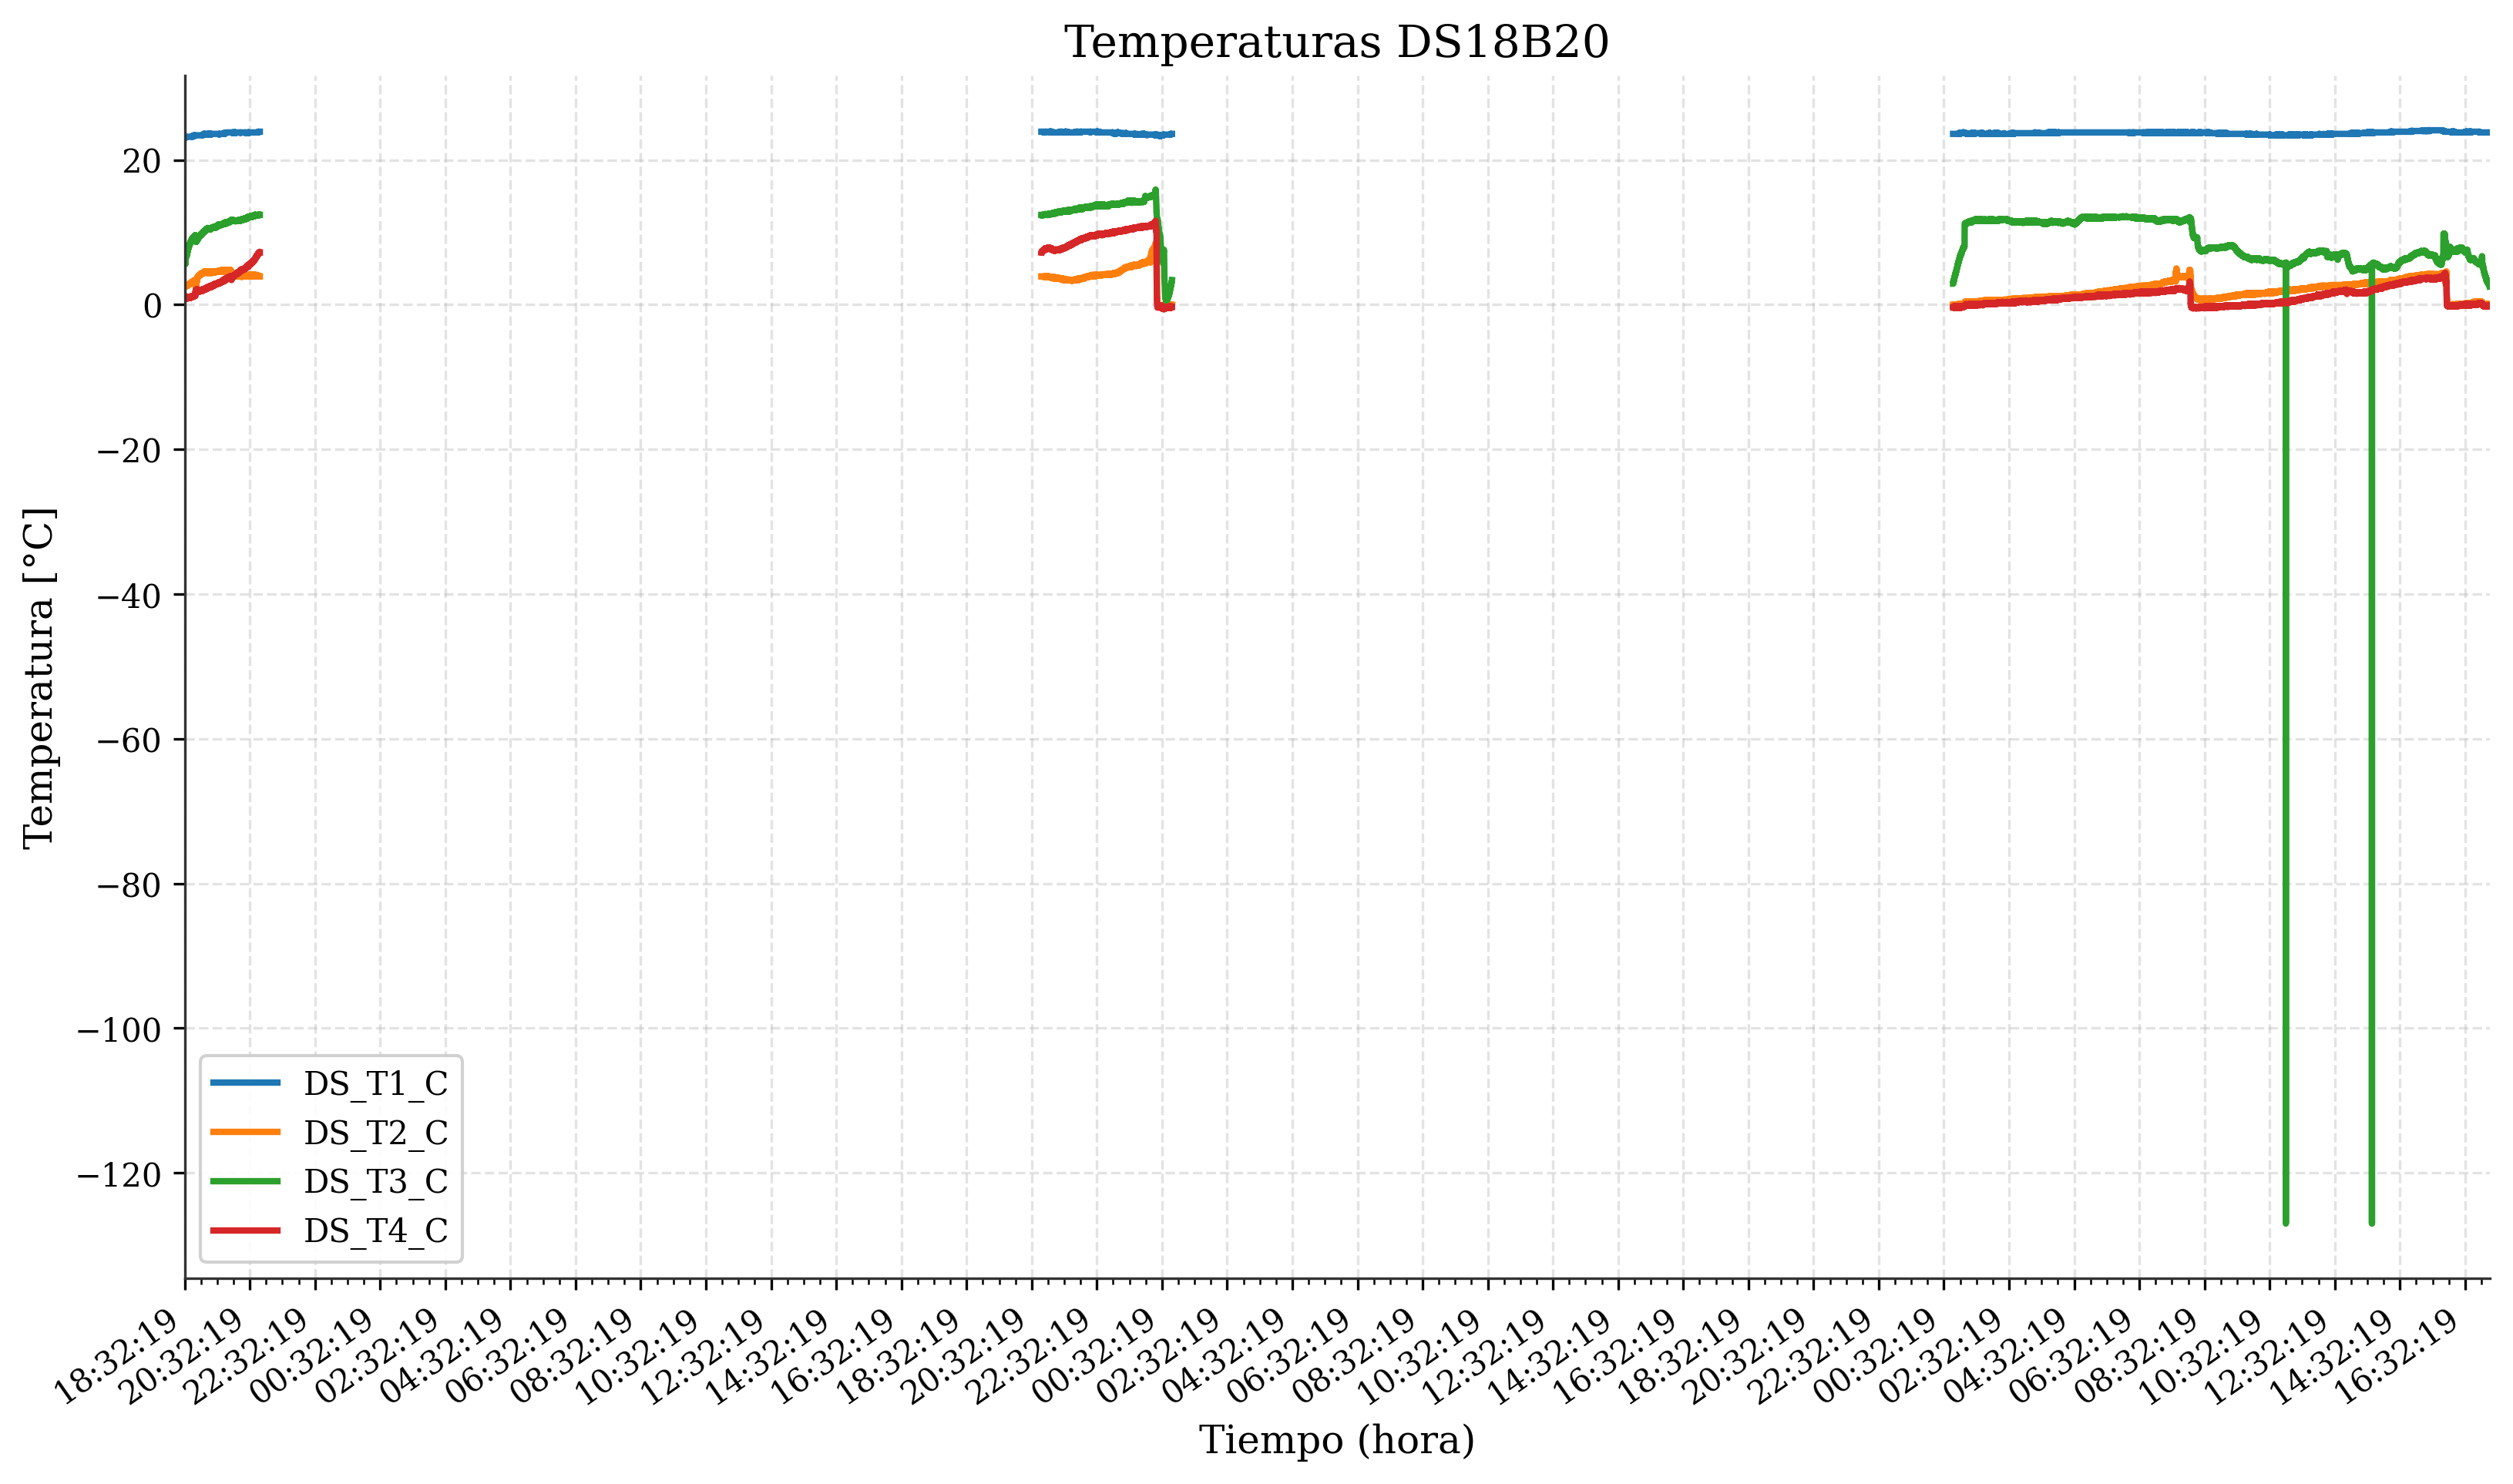

/tmp/ipython-input-3105832059.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start = pd.to_datetime(x_dt.iloc[0]).round('S')


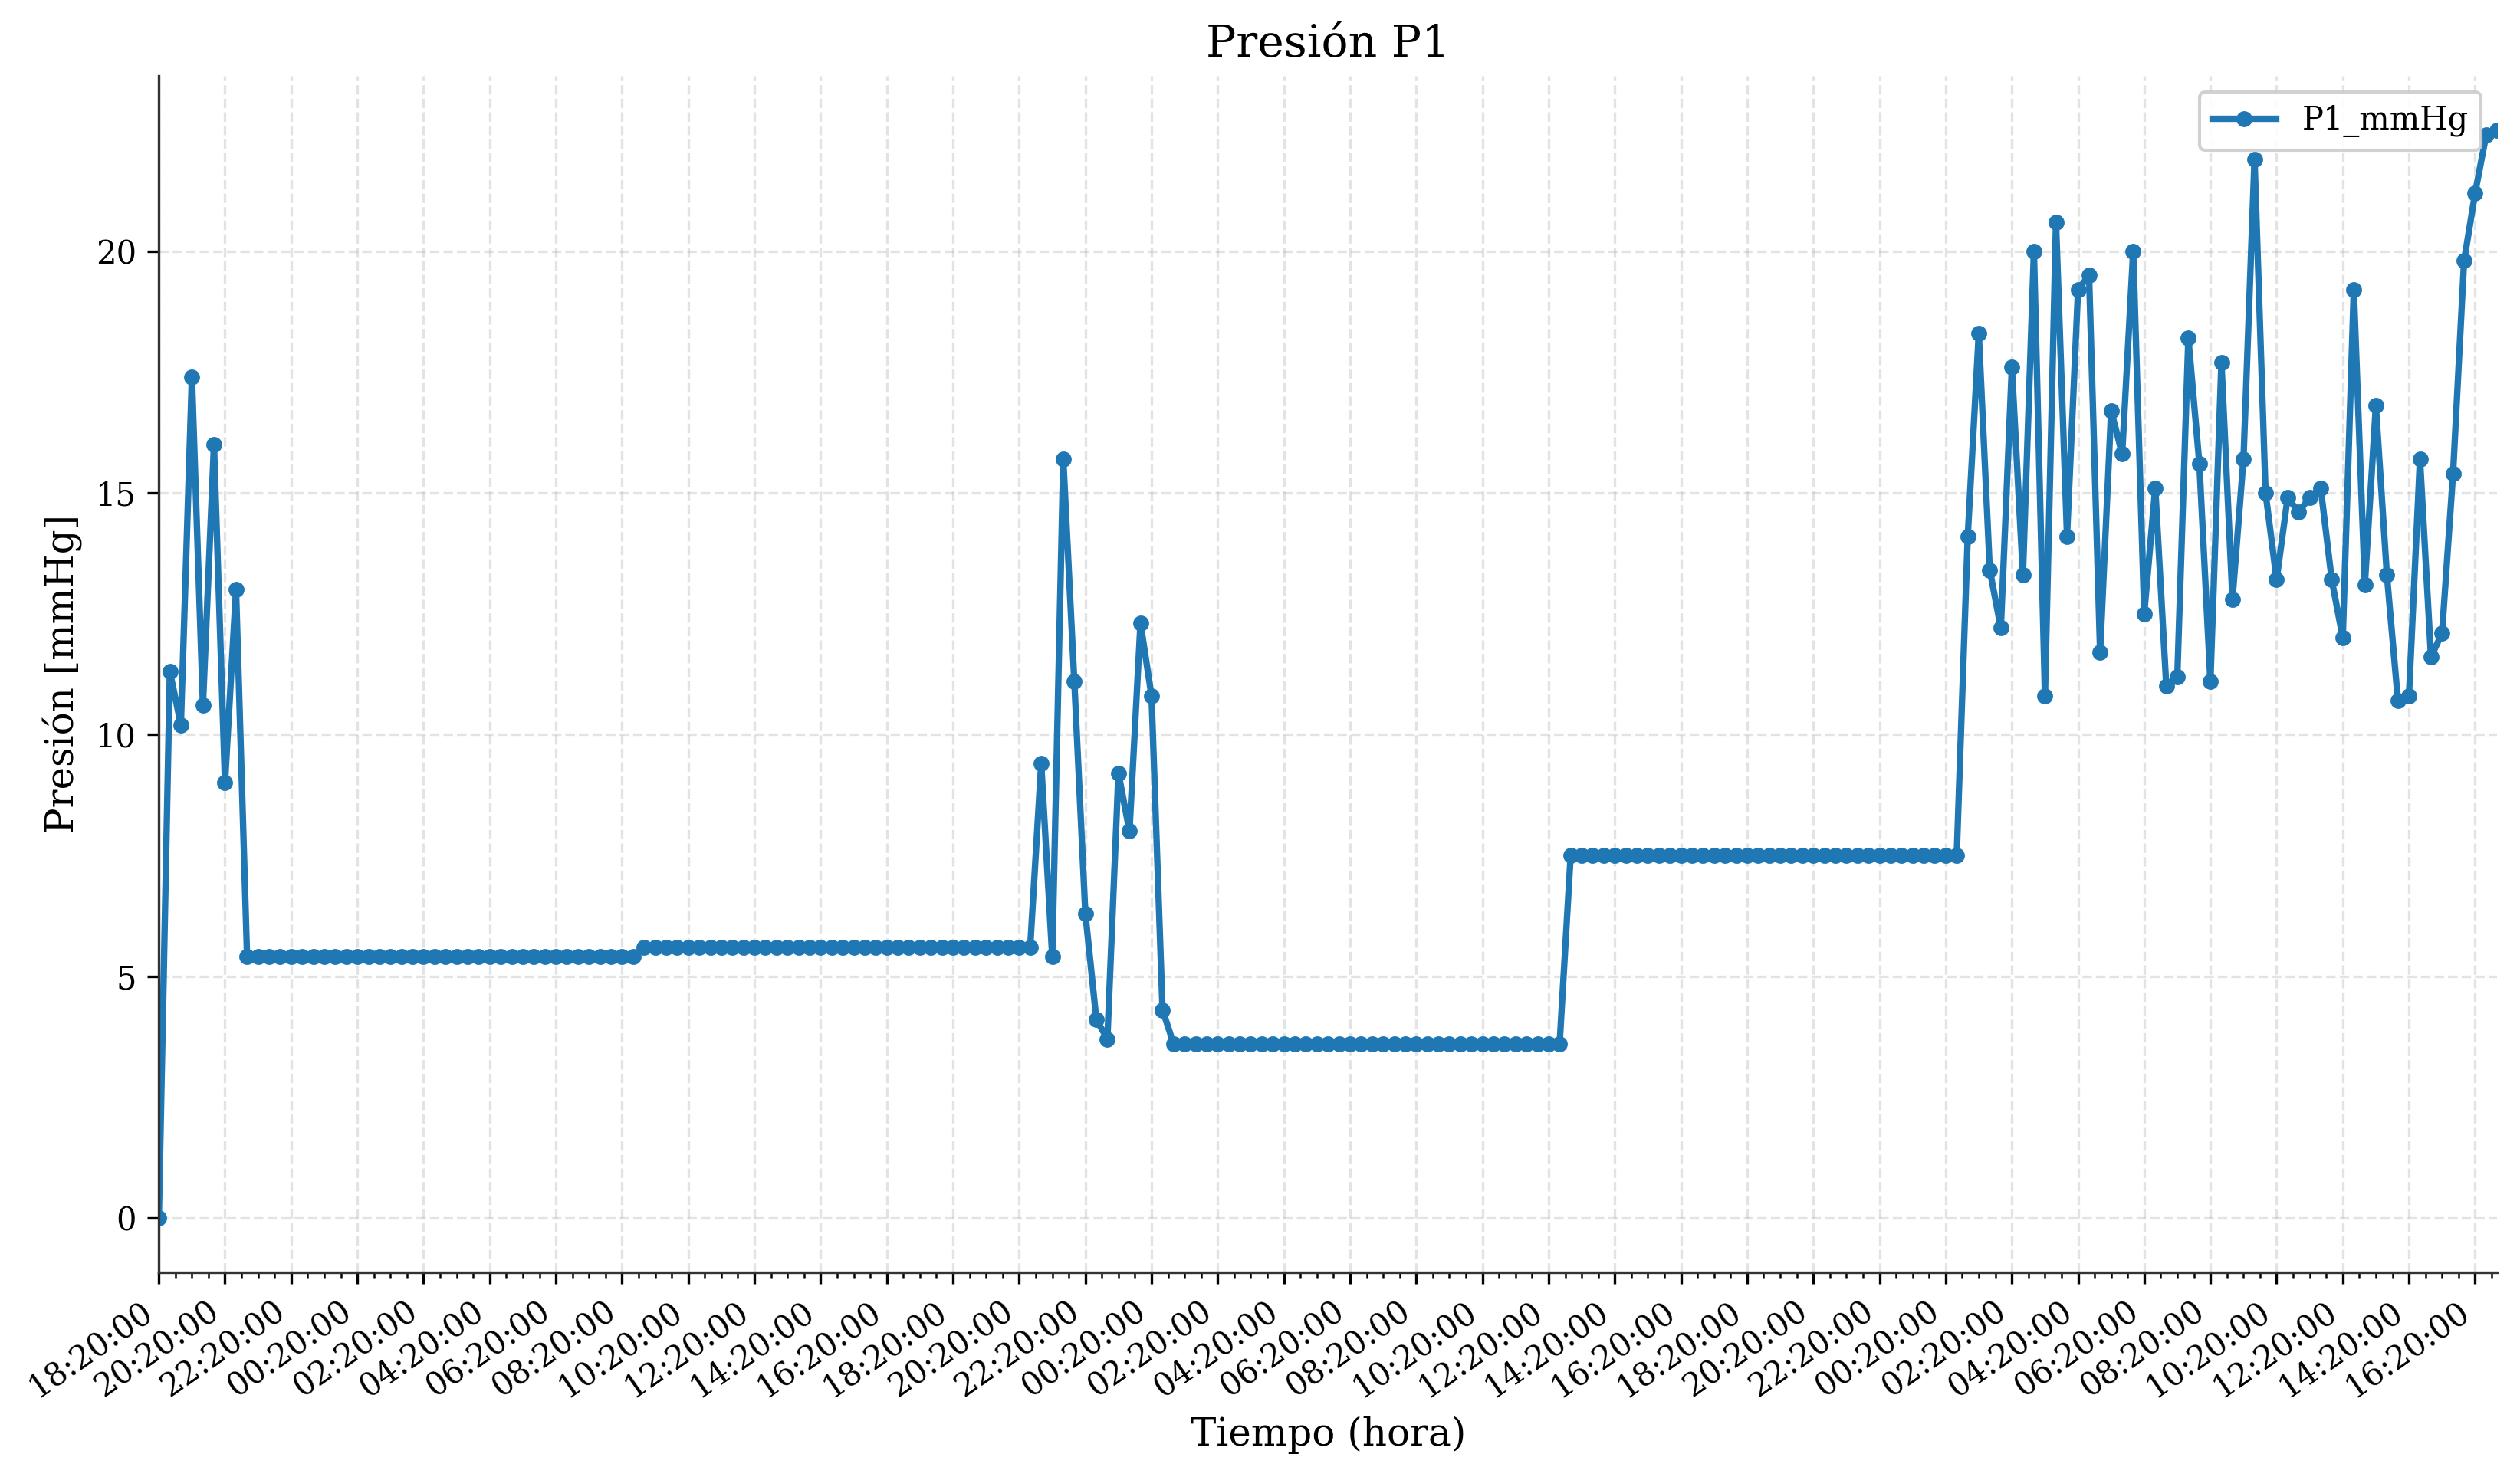

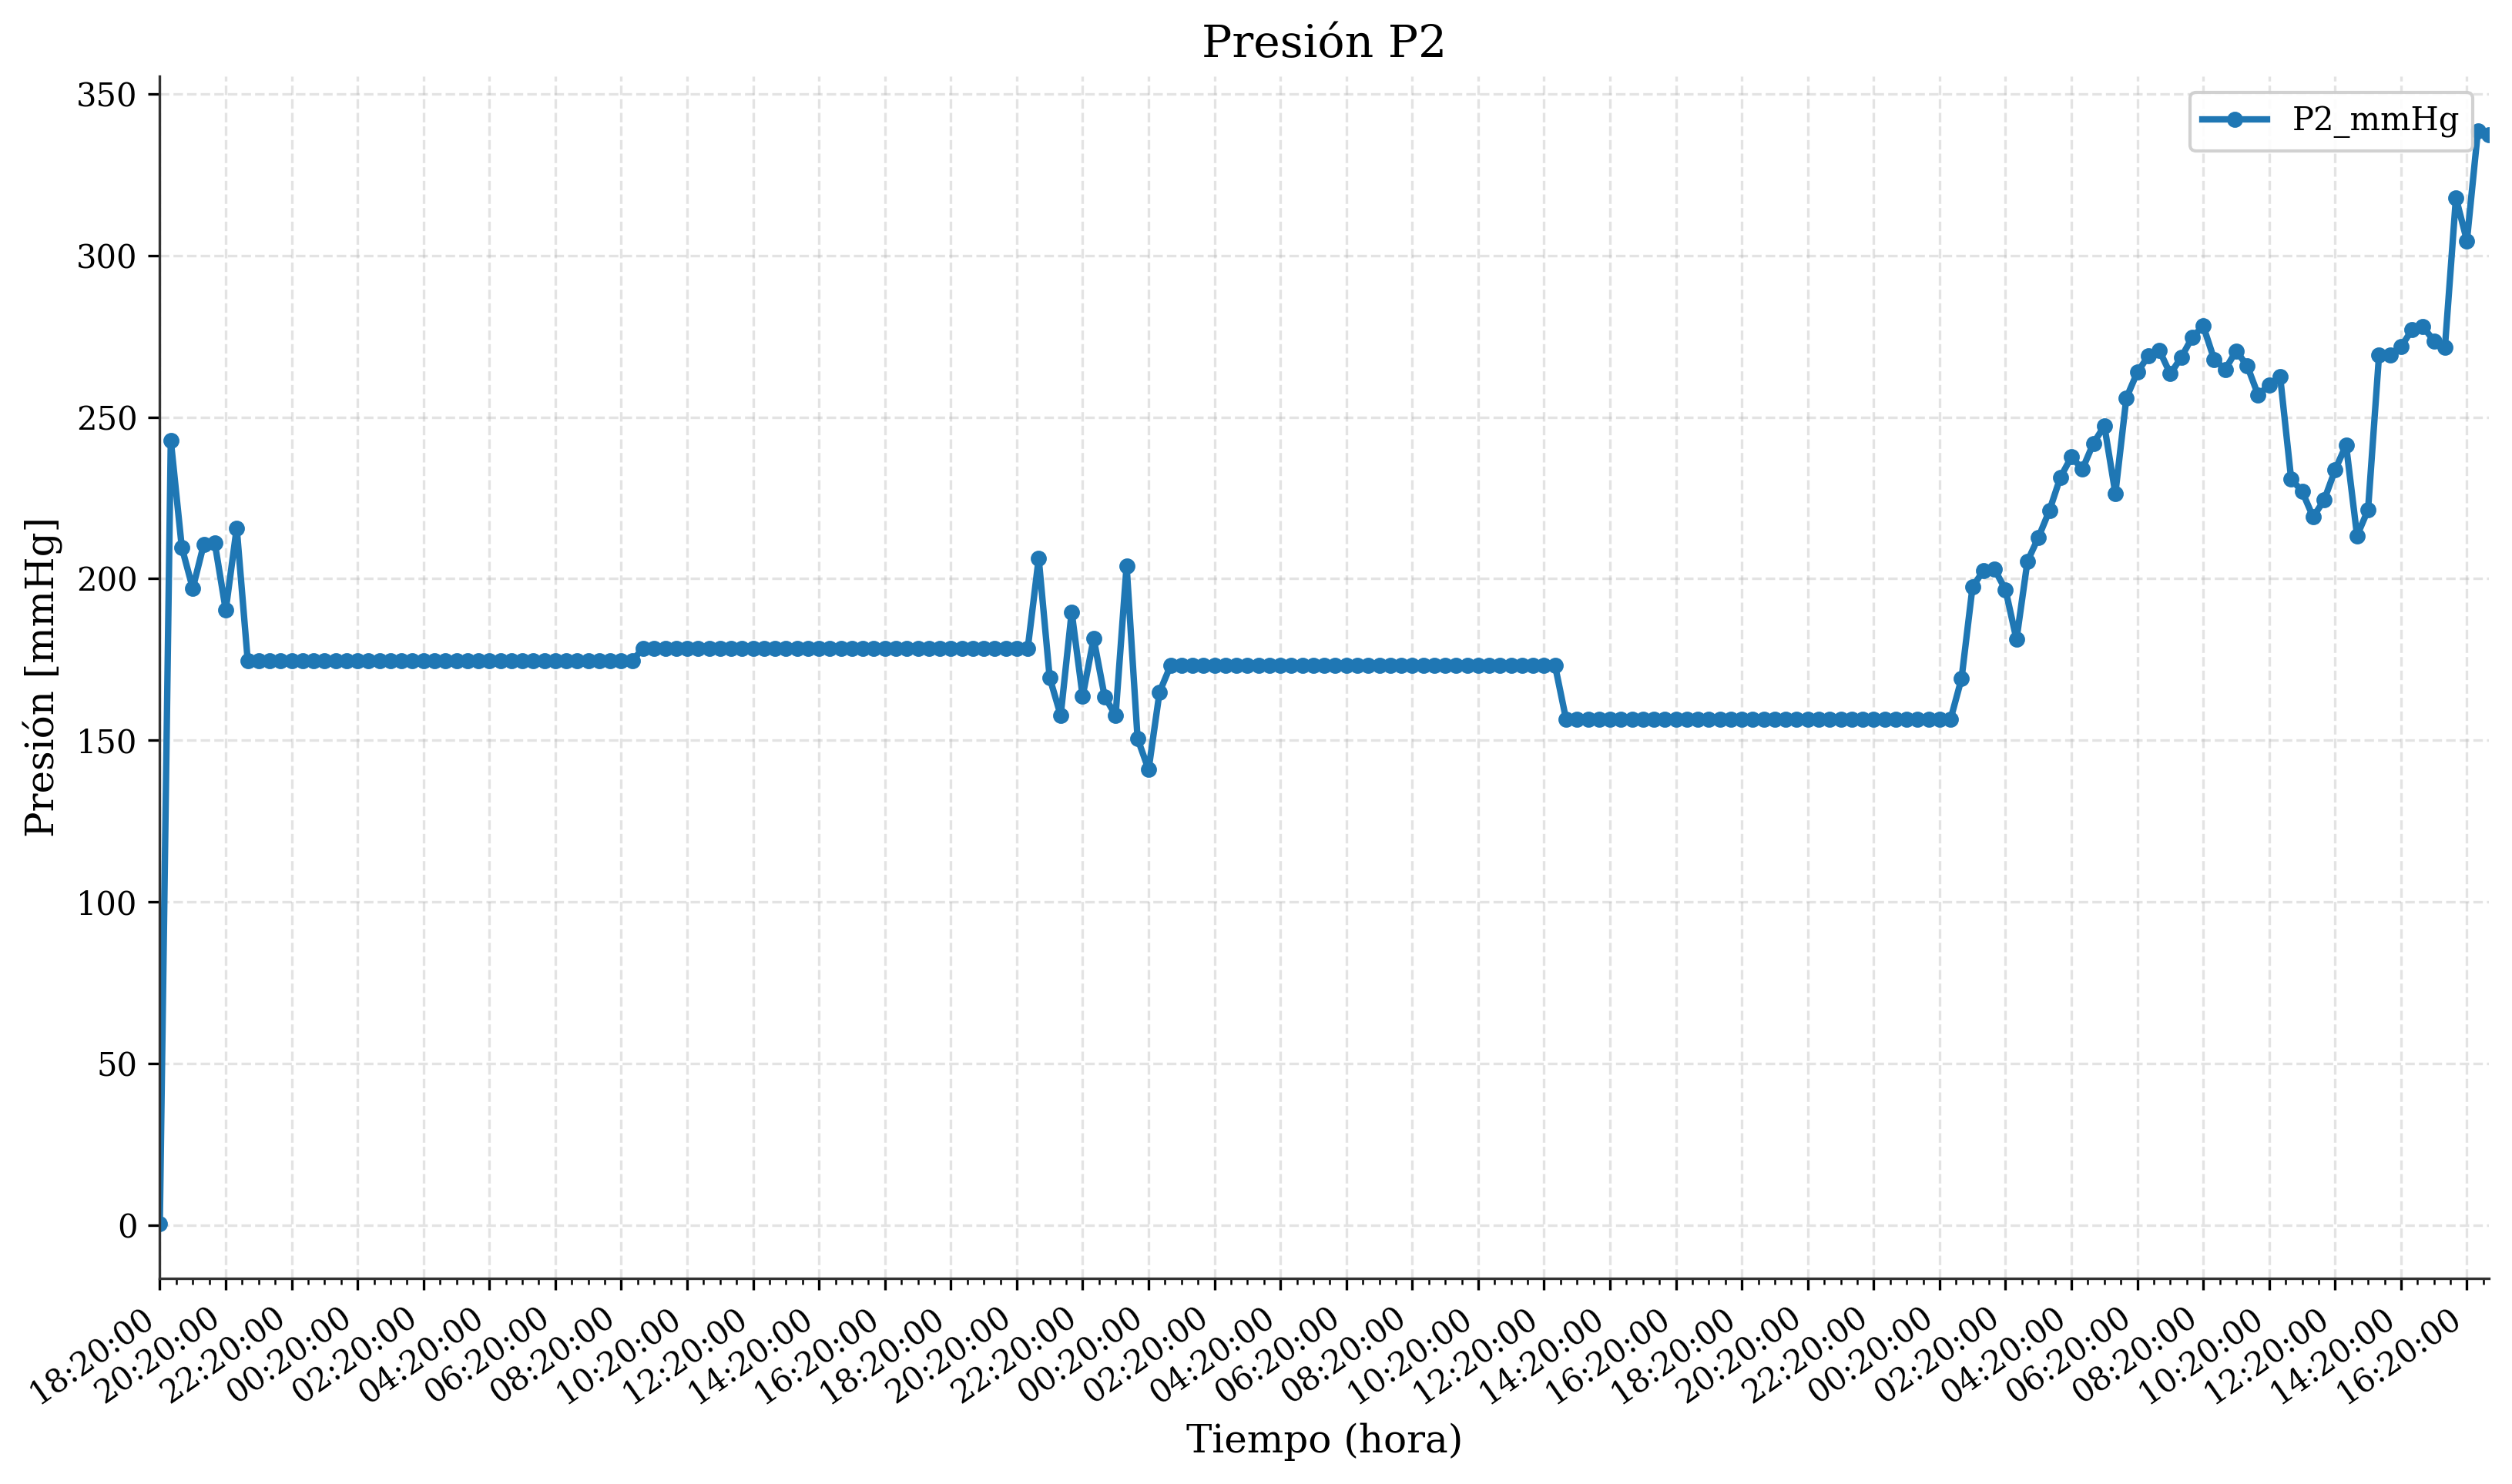

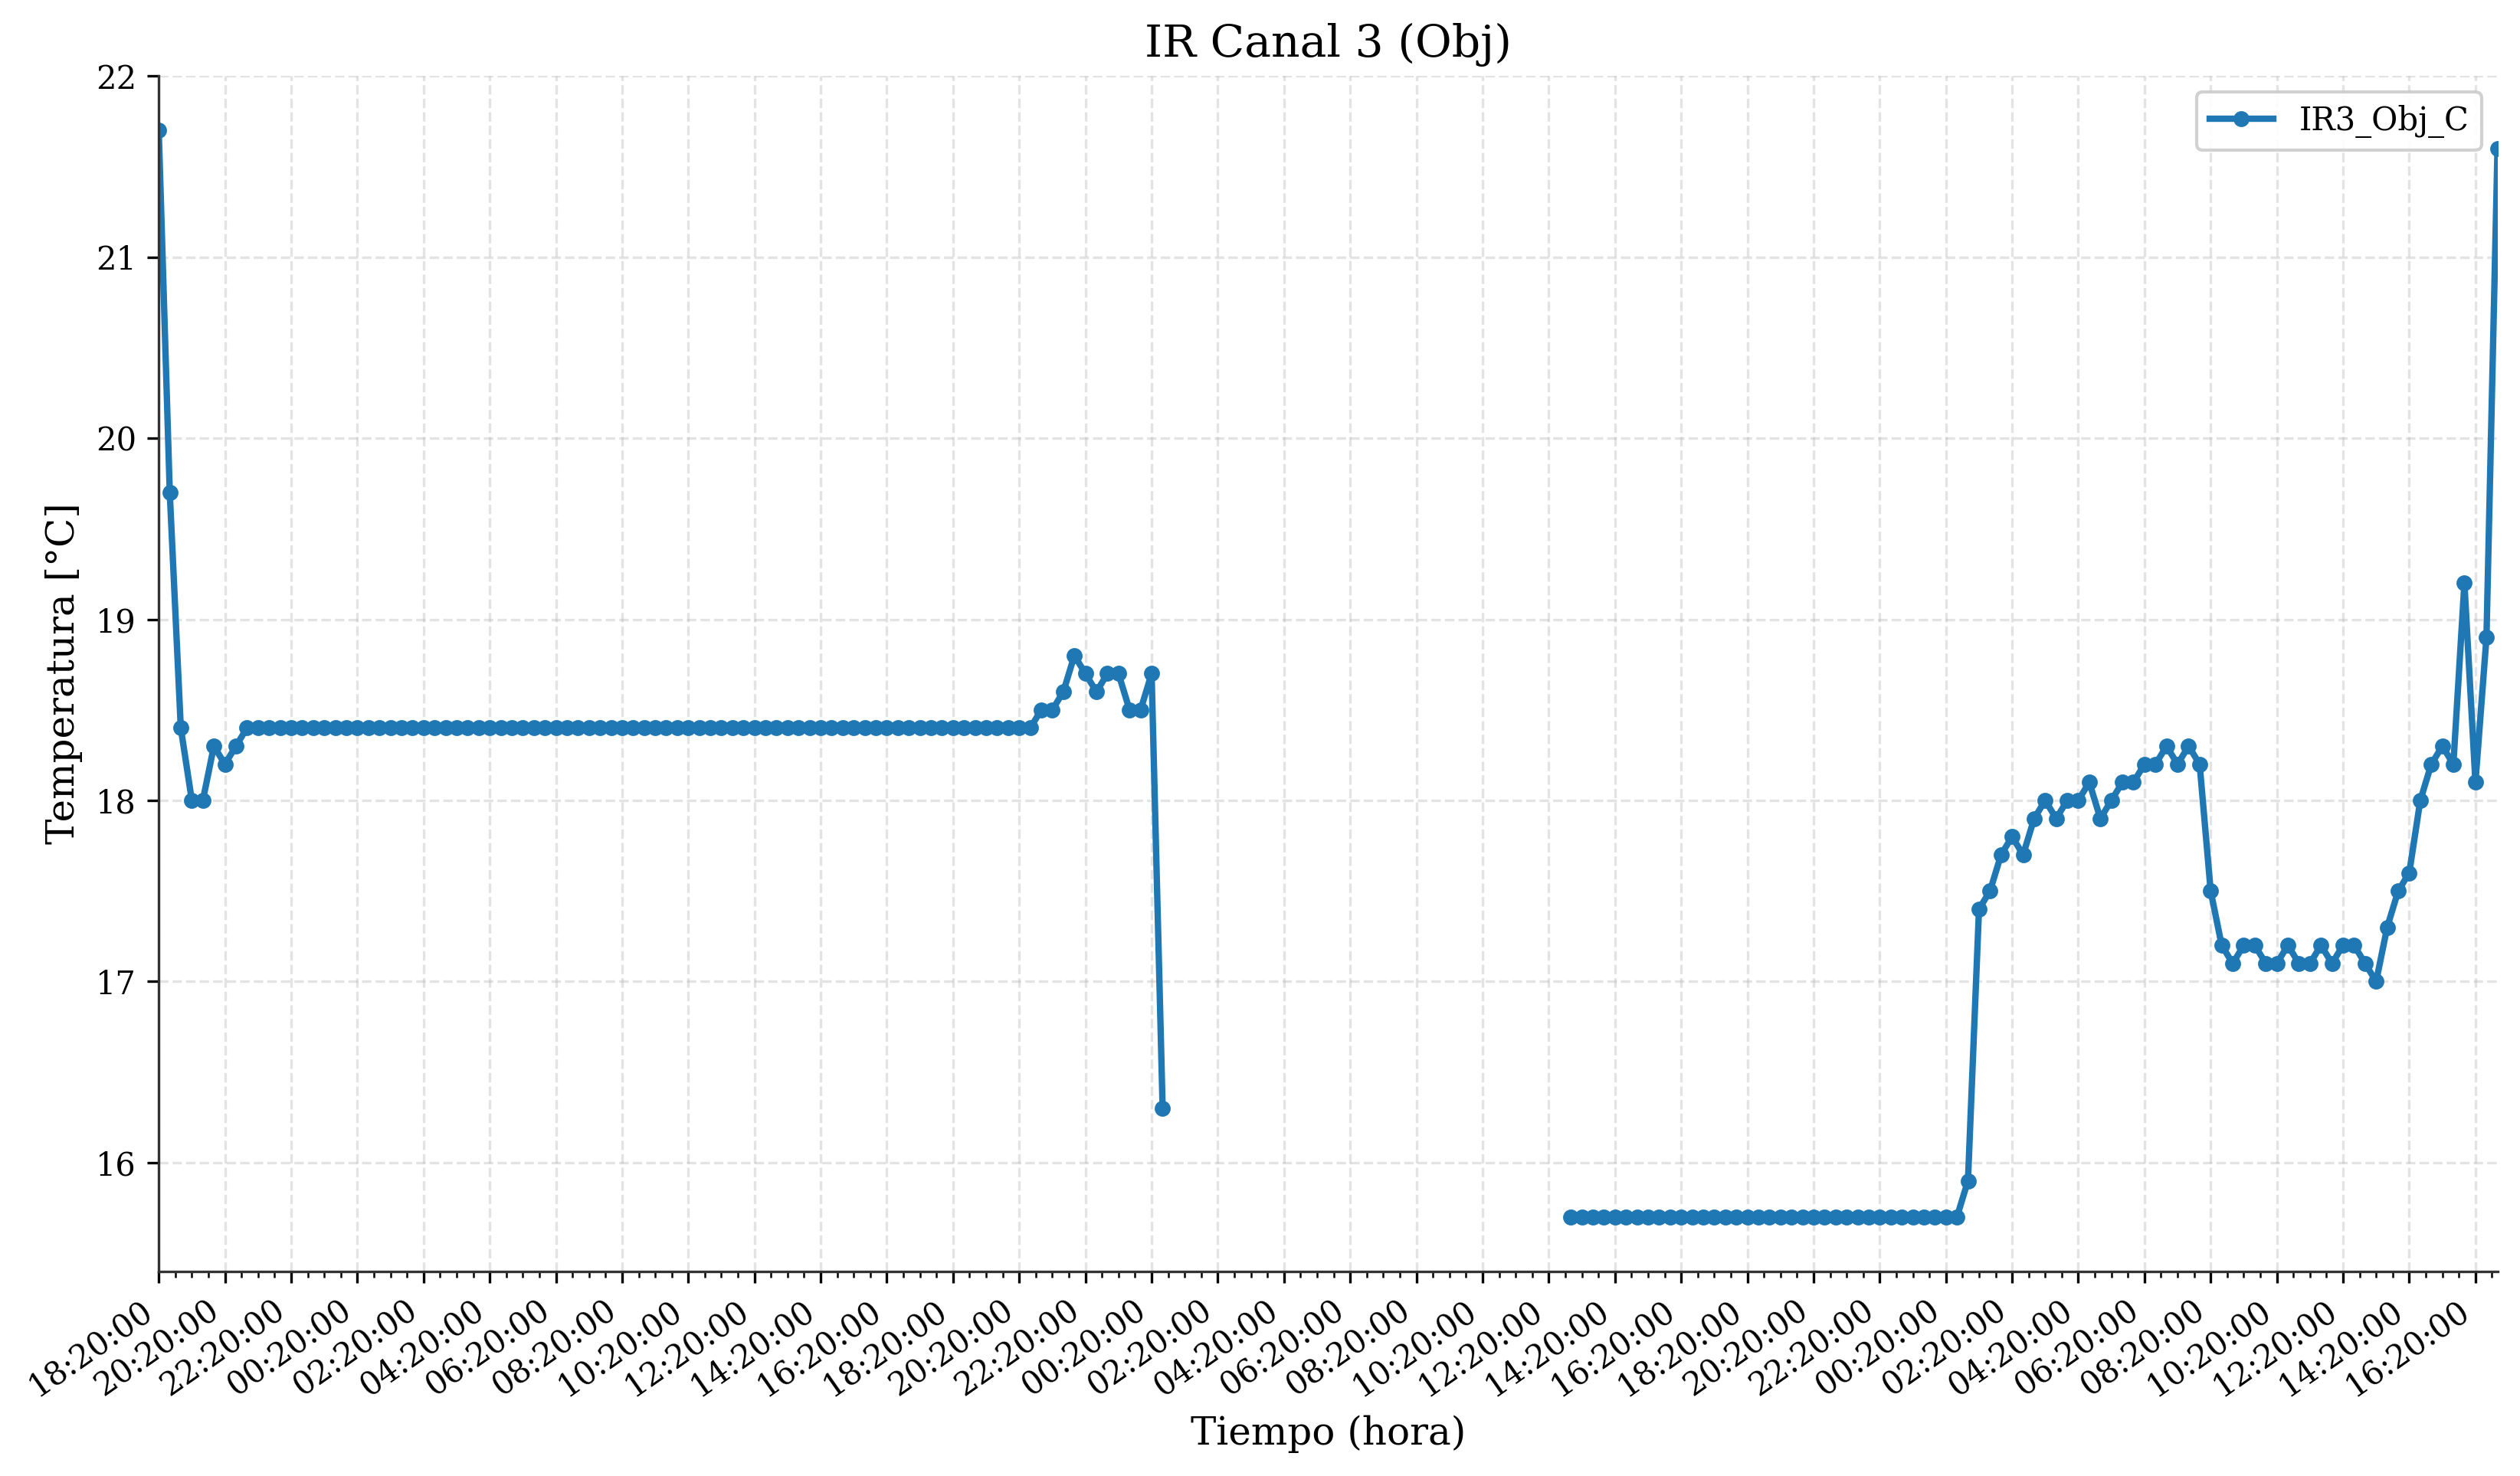

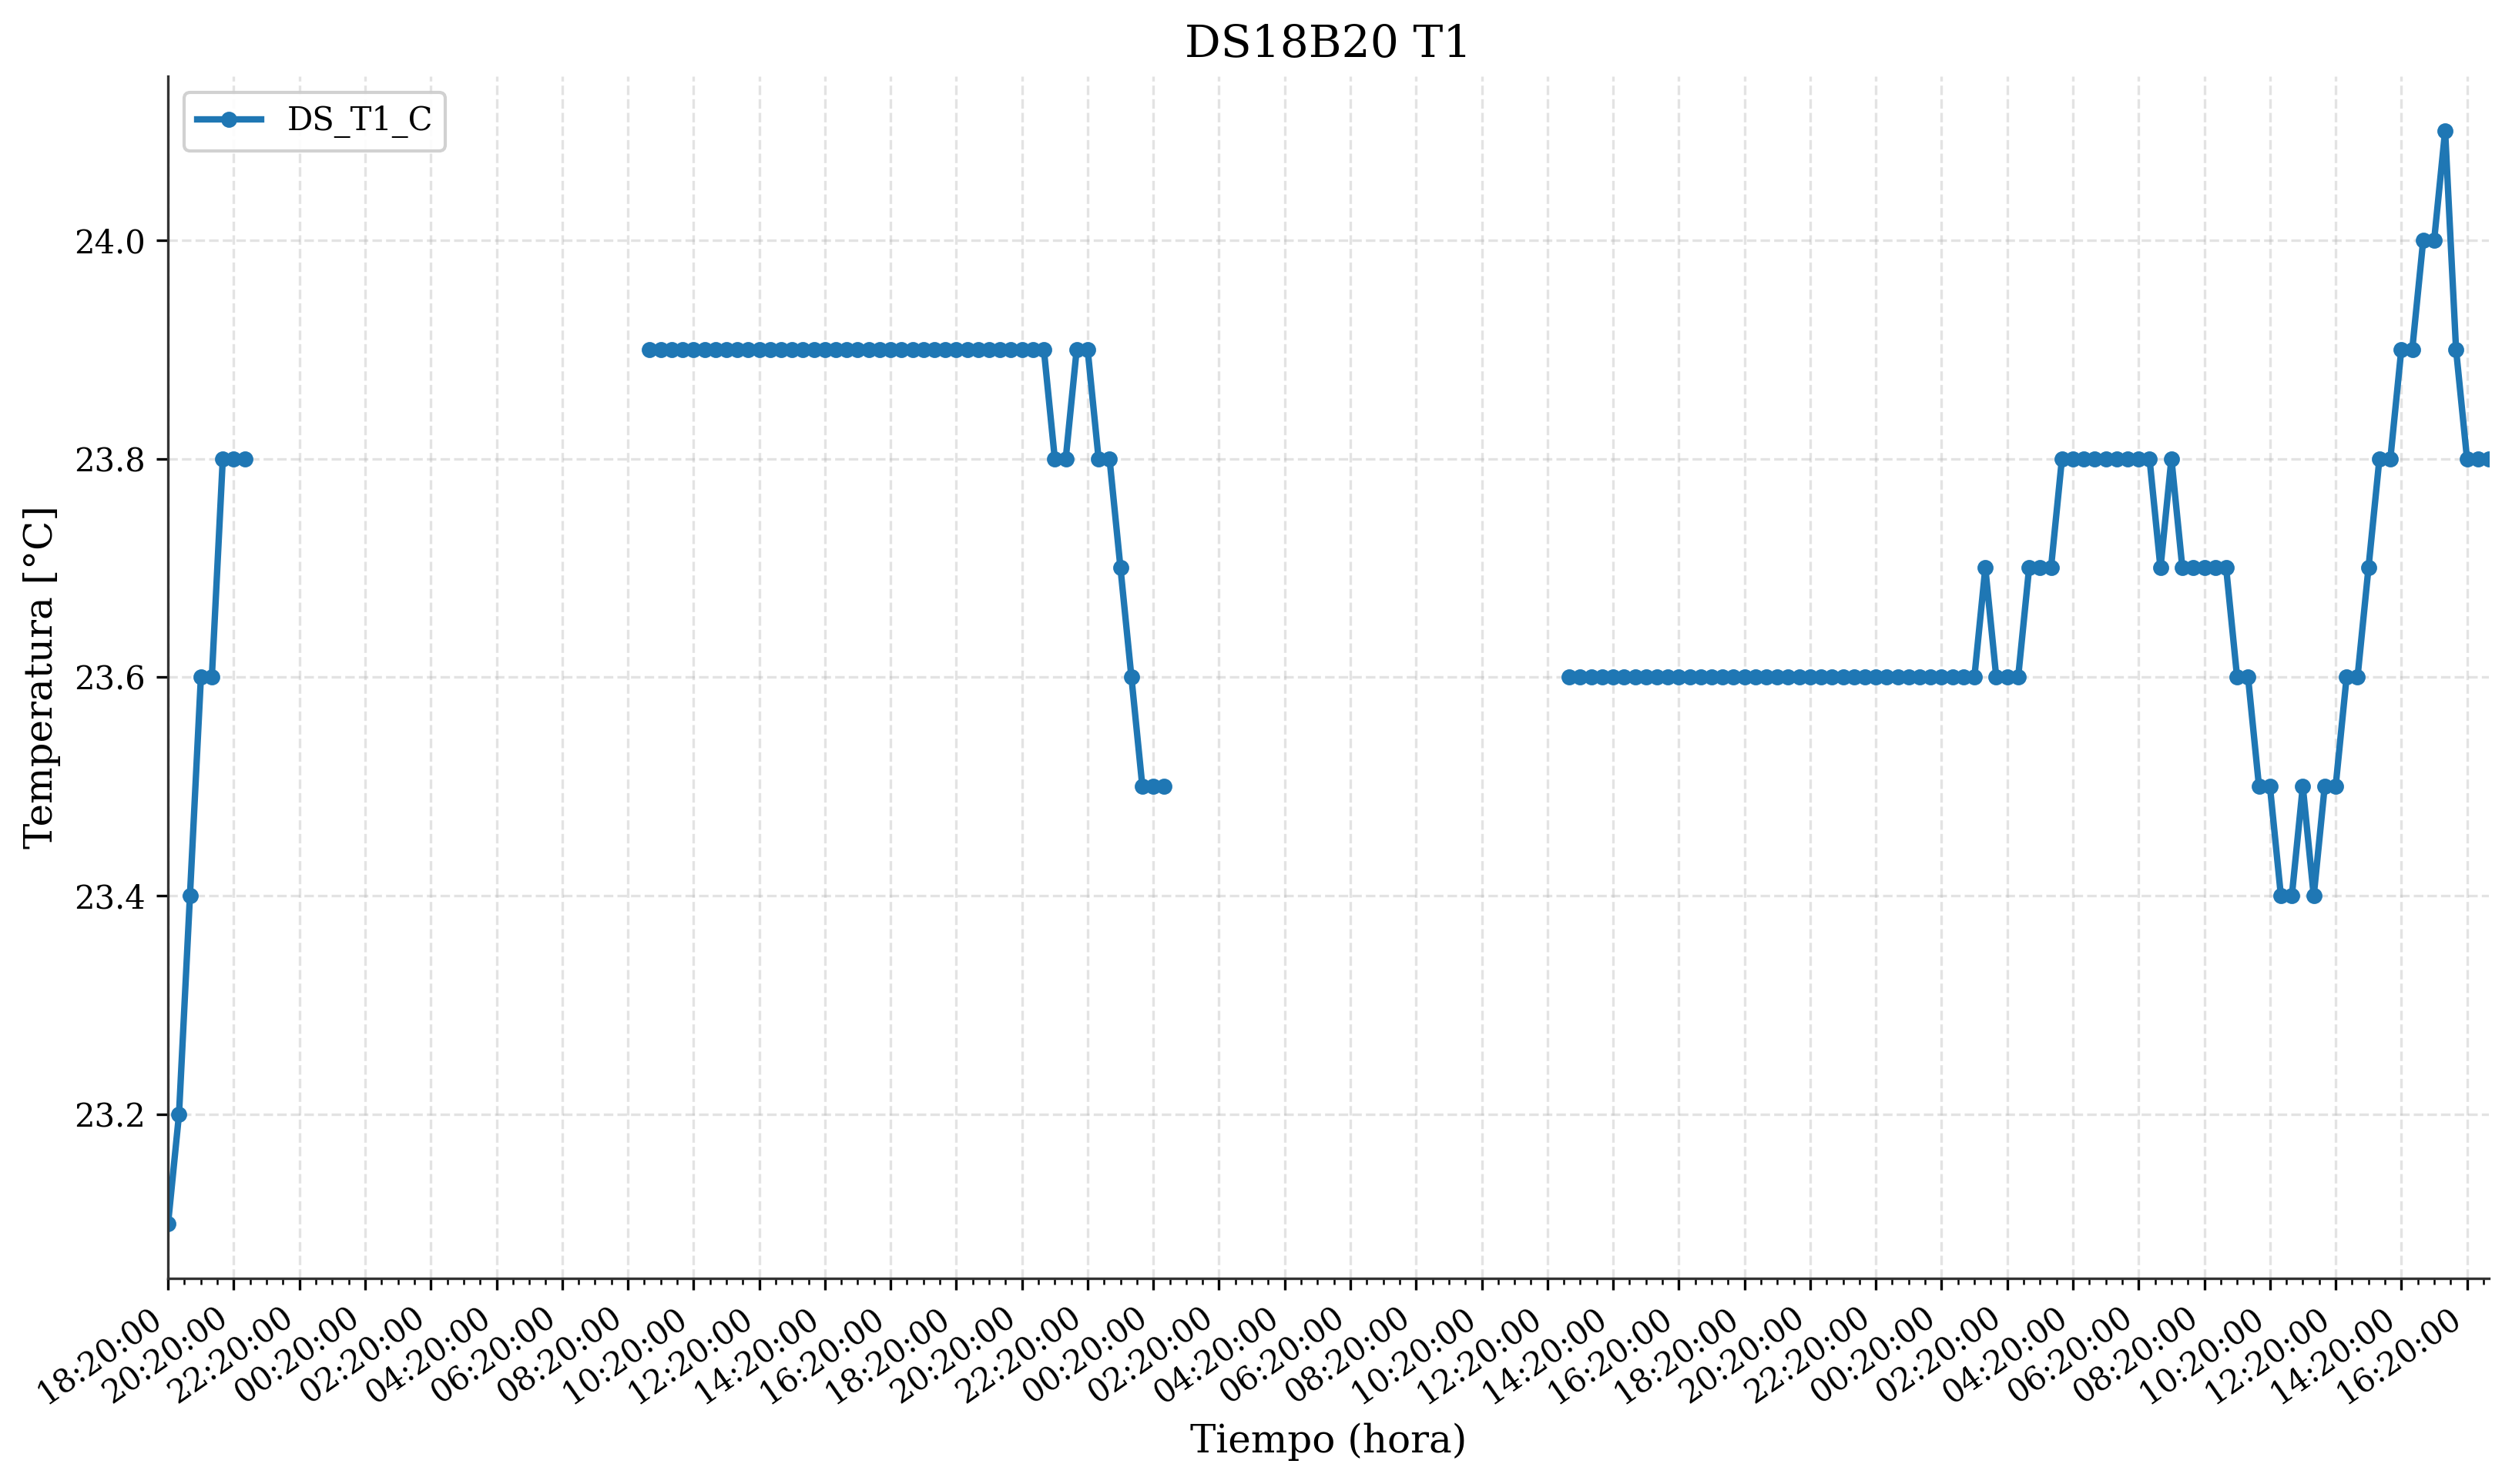

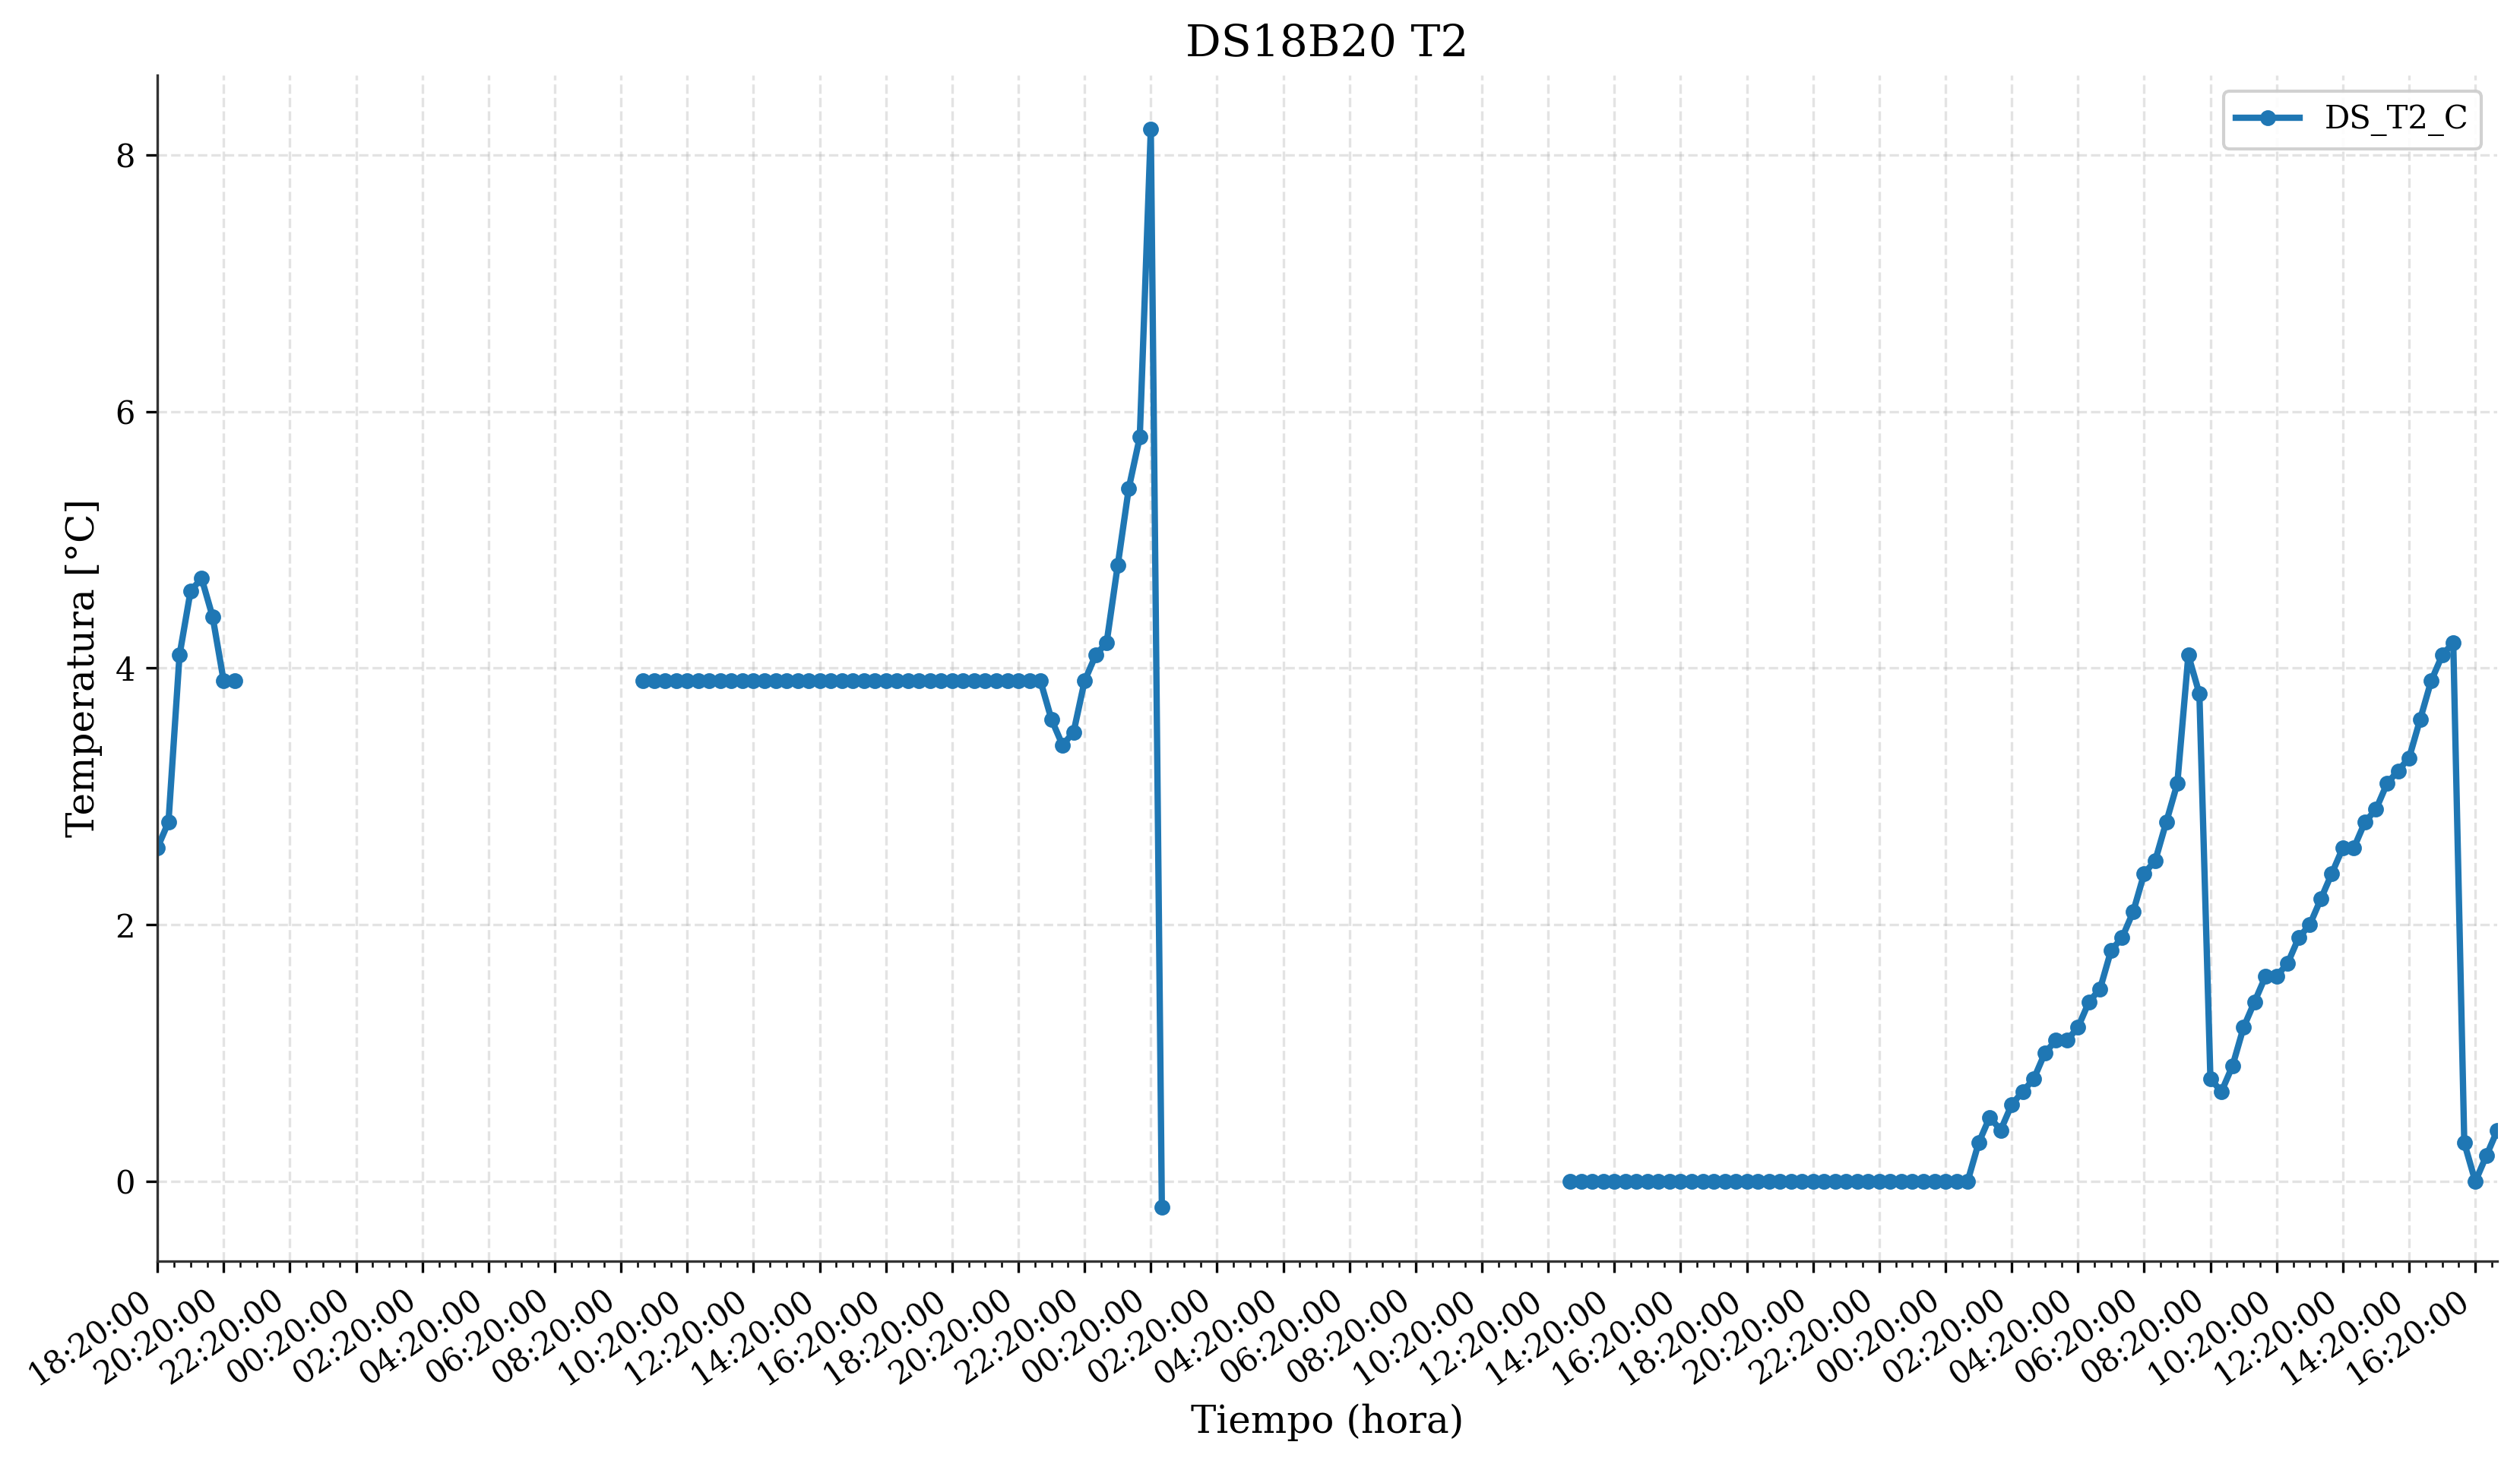

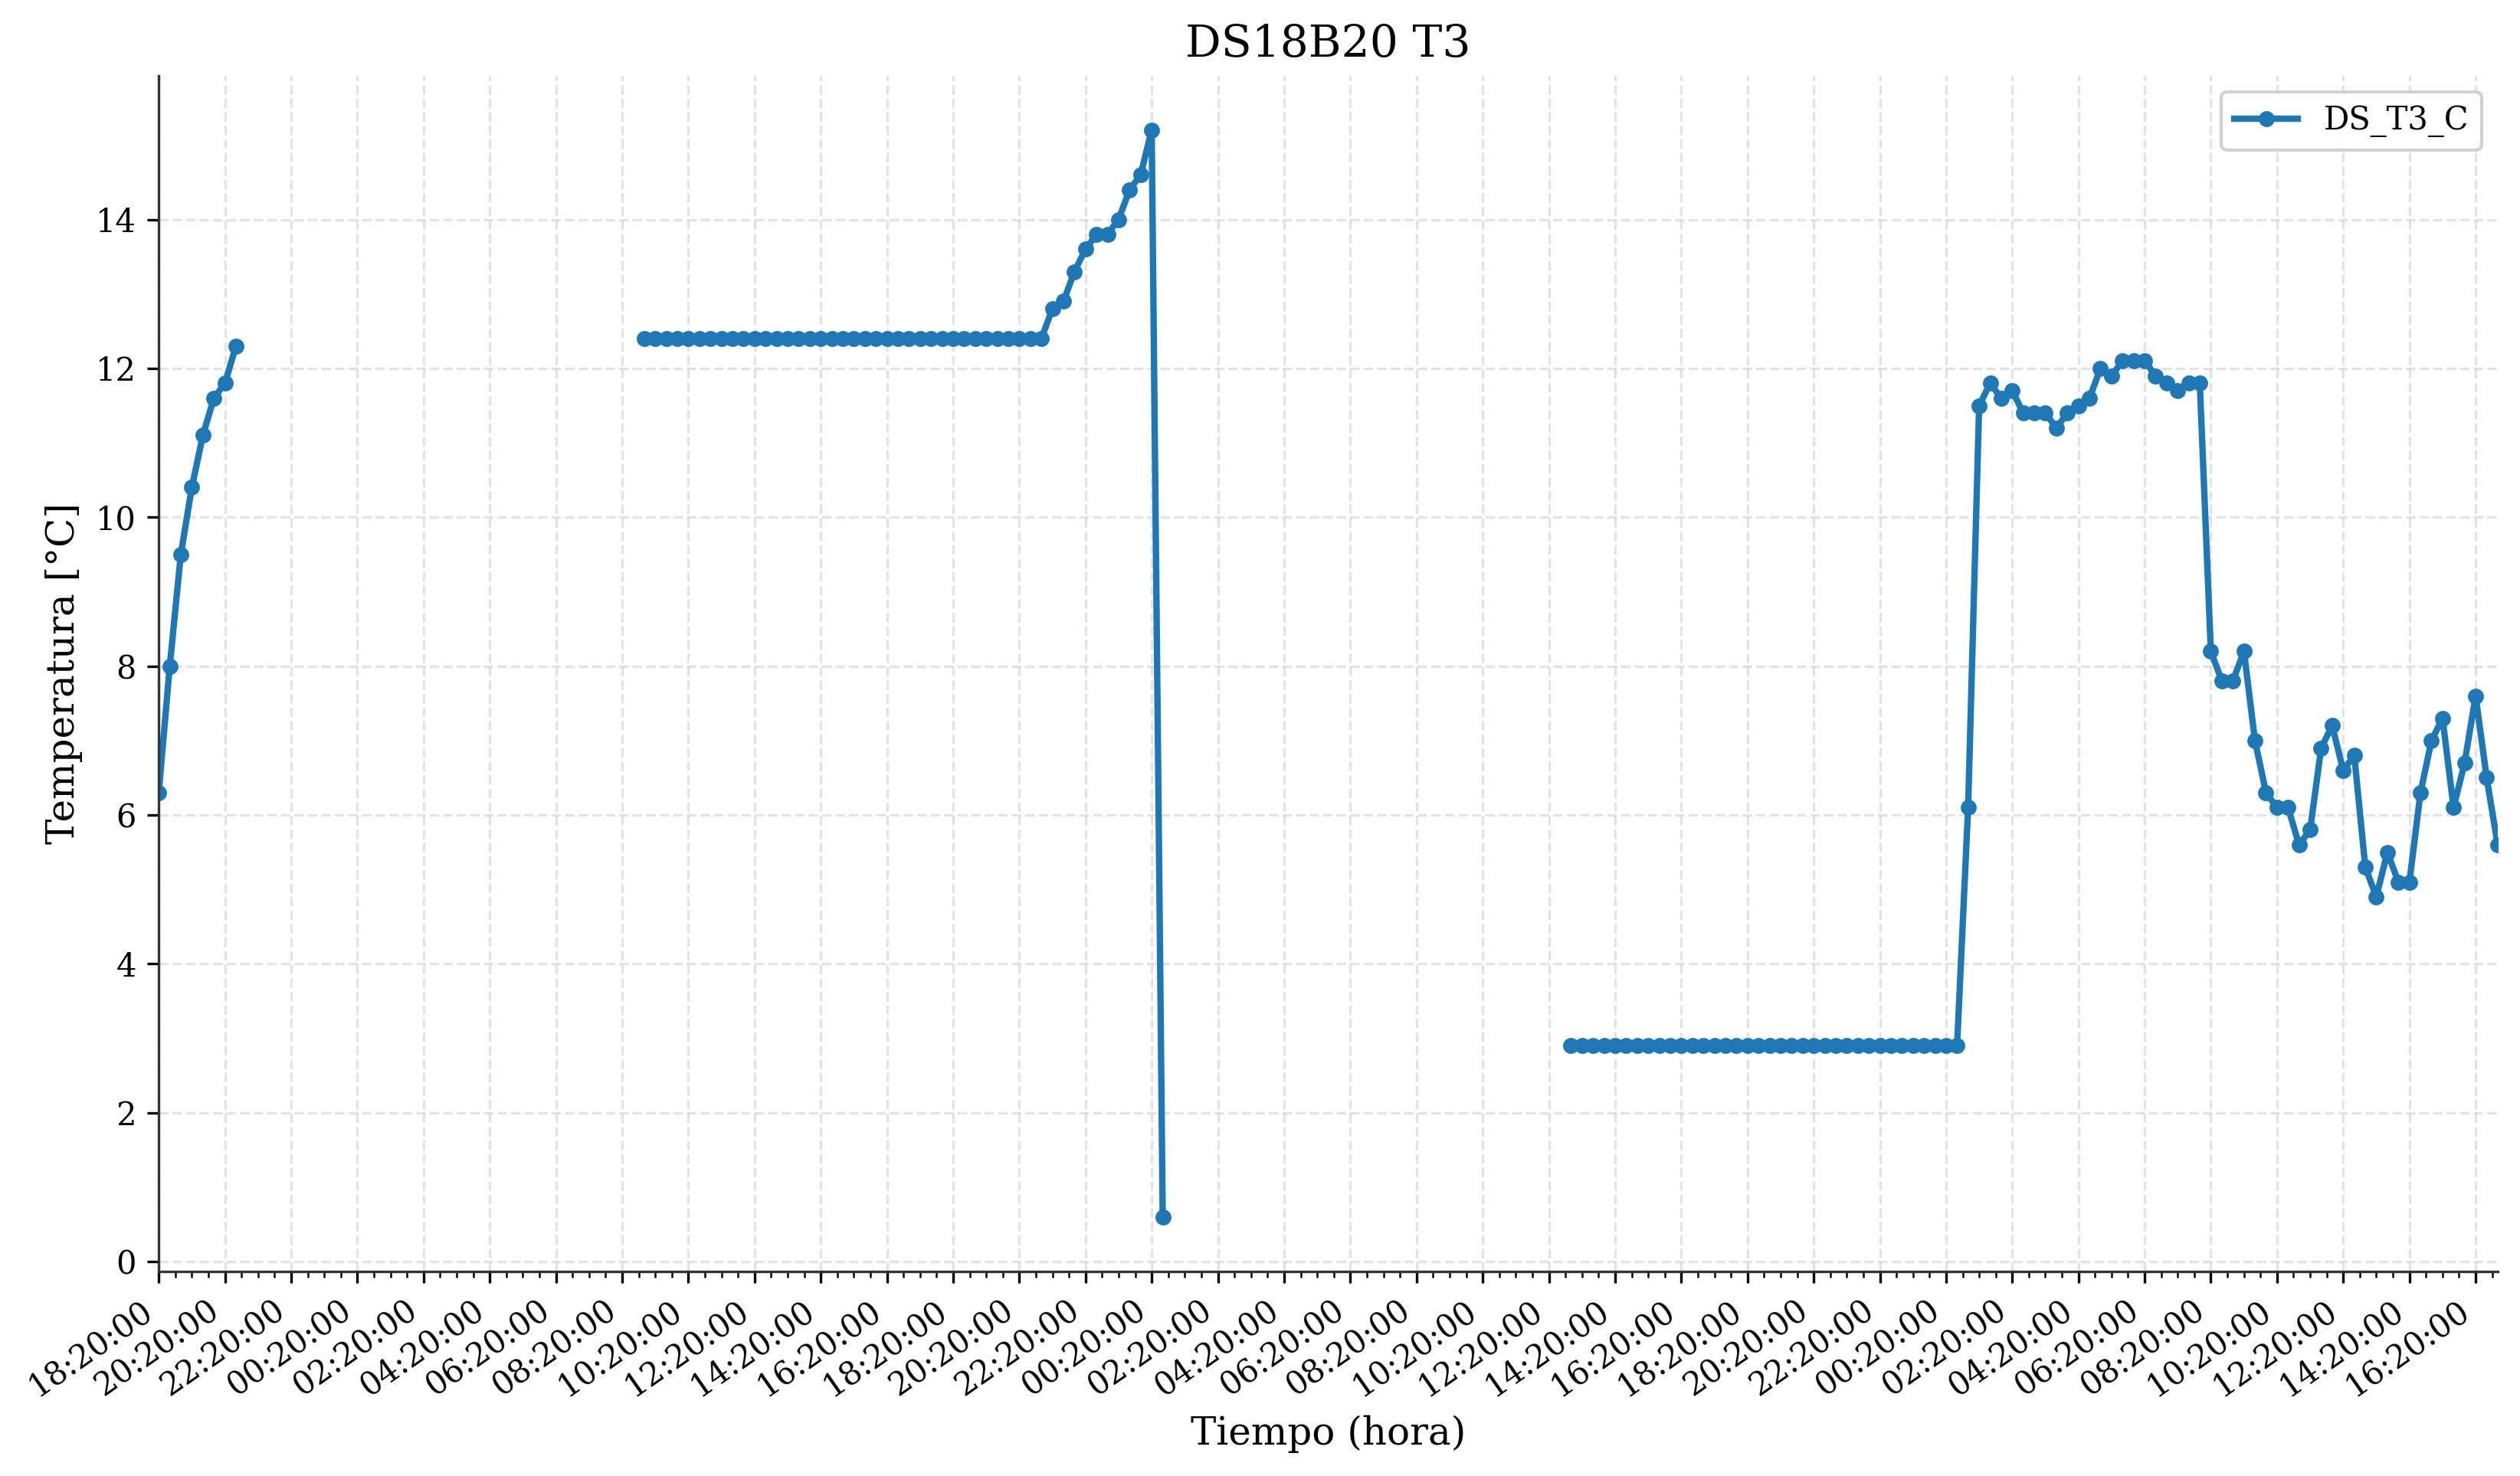

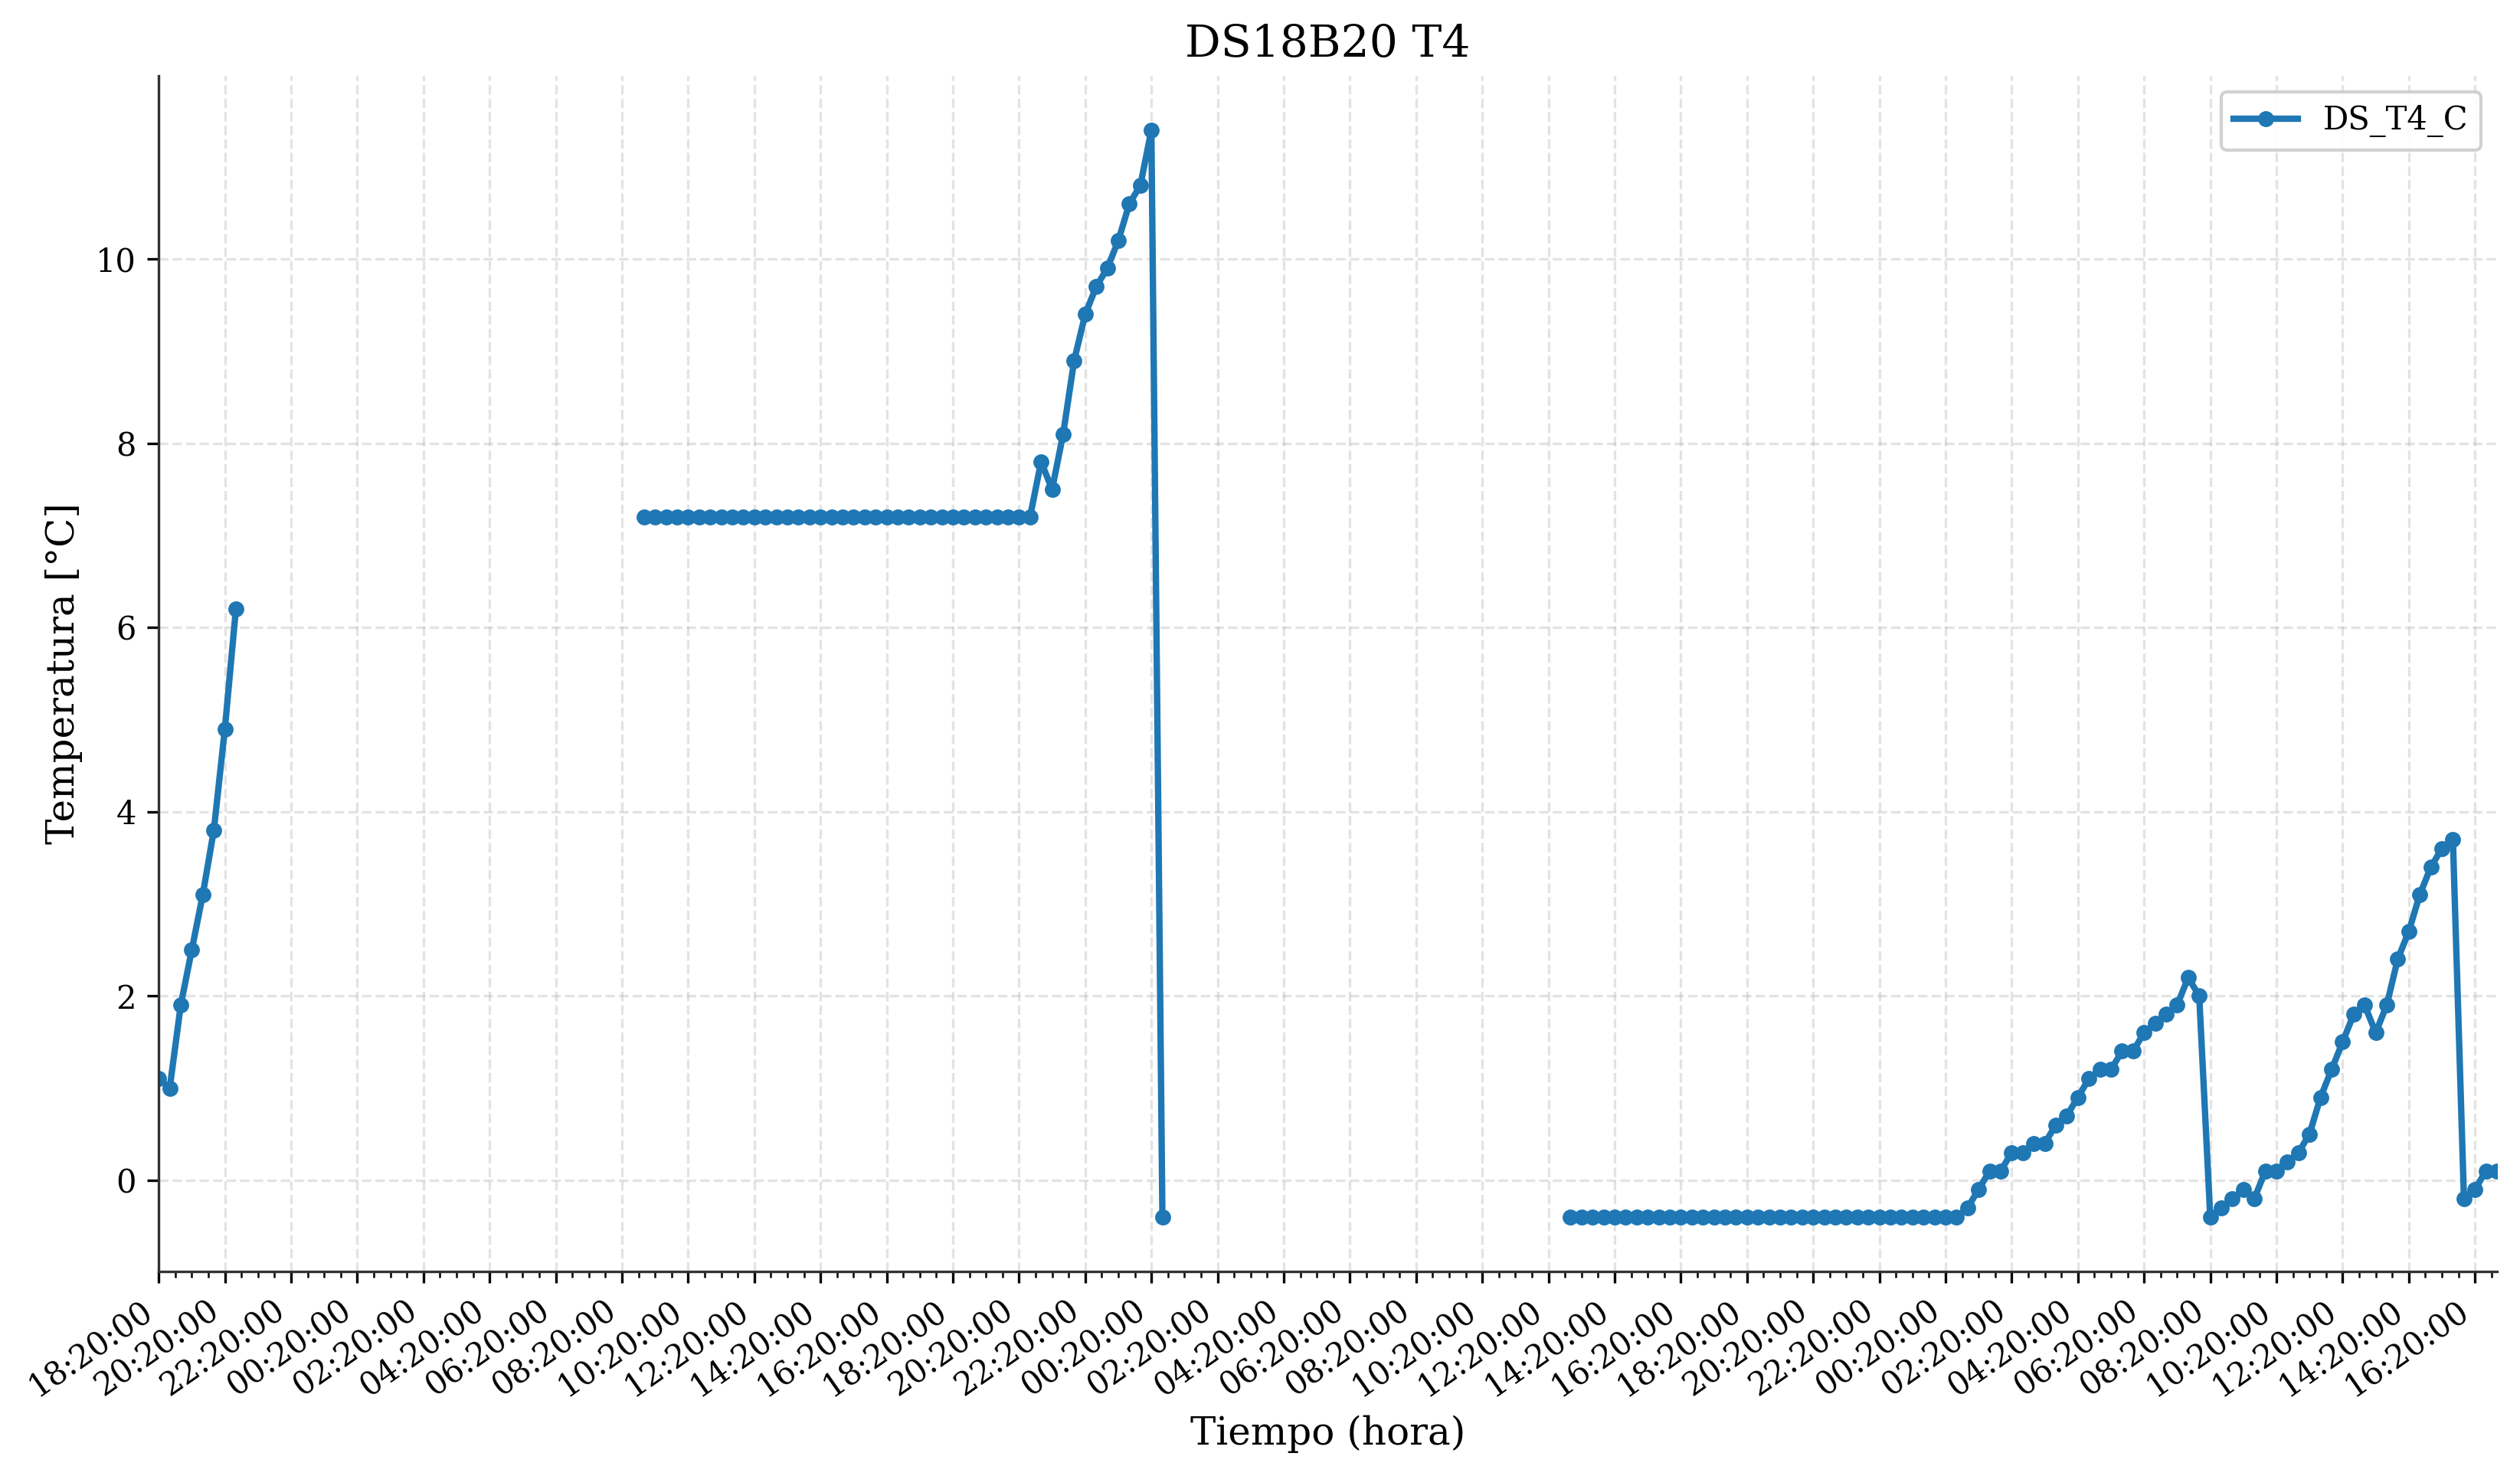

✅ Figuras generadas con formato de informe profesional.


In [13]:
# -*- coding: utf-8 -*-
"""
Graficación profesional (formato de informe):
- Gráficas globales (P1/P2, IR2/IR3, DS18B20 T1–T4)
- Gráficas individuales (cada sensor) con muestreo configurable
- Ejes HH:MM:SS, grilla anclada al primer dato
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Tuple

# ================== CONFIGURACIÓN GENERAL ==================
CSV_PATH       = "salida_unida.csv"  # Archivo combinado
OUT_PREFIX     = "fig_"
SAVE_PNGS      = True
SAVE_PDFS      = False
SHOW_PLOTS     = True
DPI            = 300
FIGSIZE        = (11, 6)
LINEWIDTH      = 2.0
MARKERSIZE     = 0
GRID_ALPHA     = 0.35

USE_ELAPSED    = False               # False → eje HH:MM:SS, True → elapsed_s
SAMPLE_INTERVAL = "30min"            # Muestreo individual (cambia a "15min" si quieres)
GLOBAL_MAJOR    = "120min"            # Grilla mayor global
GLOBAL_MINOR    = "30min"             # Grilla menor global
ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')

# ===========================================================

# ---- Estilo global de informe ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

# ================== FUNCIONES AUXILIARES ==================

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """Convierte la columna de hora (HH:MM:SS.mmm) en datetime continuo cosiendo medianoches."""
    t_norm = time_series.astype(str).str.replace(",", ".", regex=False).str.strip()
    base = "2000-01-01 "
    dt = pd.to_datetime(base + t_norm, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
    neg = dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    return dt + pd.to_timedelta(roll, unit="D")

def construir_x(df: pd.DataFrame) -> pd.Series:
    if USE_ELAPSED:
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
    else:
        return construir_tiempo_continuo(df["time"])

def set_time_ticks(ax, x_dt, major: Optional[str], minor: Optional[str]):
    """Configura ticks y grilla desde el primer dato, con formato HH:MM:SS y etiquetas rotadas."""
    start = pd.to_datetime(x_dt.iloc[0]).round('S')
    end = pd.to_datetime(x_dt.iloc[-1])
    ax.set_xlim(start, end)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    if major:
        majors = pd.date_range(start, end, freq=major)
        ax.set_xticks(majors)
    if minor:
        minors = pd.date_range(start, end, freq=minor)
        ax.set_xticks(minors, minor=True)
    ax.set_xlabel("Tiempo (hora)")

    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")


def aplicar_muestreo(x_dt, df, freq):
    """Muestrea el DataFrame a intervalos fijos usando 'nearest'."""
    tmp = df.copy().assign(_x=x_dt.values)
    tmp['_x_unique'] = tmp['_x'] + pd.to_timedelta(tmp.index, unit='ns')
    tmp = tmp.set_index("_x_unique").sort_index()
    df_s = tmp.resample(freq).nearest()
    return df_s.index.to_series().reset_index(drop=True), df_s.reset_index(drop=True)

def _save_and_show(fig, fname_base: str):
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def style_axes(ax, titulo, ylabel):
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    plt.tight_layout()

# ================== GRAFICACIÓN ==================

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname):
    fig, ax = plt.subplots()
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).any():
                ax.plot(x_dt, y, label=col)
    style_axes(ax, titulo, ylabel)
    set_time_ticks(ax, x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    _save_and_show(fig, fname)

def plot_individuales(x_dt, df):
    x_s, df_s = aplicar_muestreo(x_dt, df, SAMPLE_INTERVAL)
    columnas = [
        ("P1_mmHg","Presión P1","Presión [mmHg]"),
        ("P2_mmHg","Presión P2","Presión [mmHg]"),
        ("IR2_Obj_C","IR Canal 2 (Obj)","Temperatura [°C]"),
        ("IR3_Obj_C","IR Canal 3 (Obj)","Temperatura [°C]"),
        ("DS_T1_C","DS18B20 T1","Temperatura [°C]"),
        ("DS_T2_C","DS18B20 T2","Temperatura [°C]"),
        ("DS_T3_C","DS18B20 T3","Temperatura [°C]"),
        ("DS_T4_C","DS18B20 T4","Temperatura [°C]"),
    ]
    for col, title, ylabel in columnas:
        if col in df_s.columns:
            y = pd.to_numeric(df_s[col], errors="coerce")
            if np.isfinite(y).any():
                fig, ax = plt.subplots()
                ax.plot(x_s, y, "-o", label=col, markersize=4)
                style_axes(ax, title, ylabel)
                set_time_ticks(ax, x_s, GLOBAL_MAJOR, GLOBAL_MINOR)
                #set_time_ticks(ax, x_s, major=SAMPLE_INTERVAL, minor=None)
                _save_and_show(fig, f"{col}_individual")

def plot_global(x_dt, df):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
    # Presiones
    for c in ["P1_mmHg", "P2_mmHg"]:
        if c in df.columns:
            axes[0].plot(x_dt, df[c], label=c)
    style_axes(axes[0], "Presiones vs Tiempo", "Presión [mmHg]")
    set_time_ticks(axes[0], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    # IR
    for c in ["IR2_Obj_C", "IR3_Obj_C"]:
        if c in df.columns:
            axes[1].plot(x_dt, df[c], label=c)
    style_axes(axes[1], "Temperaturas IR (Objetivo)", "Temperatura [°C]")
    set_time_ticks(axes[1], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    # DS18B20
    for c in ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"]:
        if c in df.columns:
            axes[2].plot(x_dt, df[c], label=c)
    style_axes(axes[2], "Sensores DS18B20 (T1–T4)", "Temperatura [°C]")
    set_time_ticks(axes[2], x_dt, GLOBAL_MAJOR, GLOBAL_MINOR)
    plt.tight_layout()
    _save_and_show(fig, "global_subplots")

# ================== EJECUCIÓN ==================

def main():
    df = pd.read_csv(CSV_PATH)
    x_dt = construir_x(df)
    plot_global(x_dt, df)
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df, "Presiones", "Presión [mmHg]", "presiones_global")
    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df, "Temperaturas IR", "Temperatura [°C]", "ir_global")
    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df, "Temperaturas DS18B20", "Temperatura [°C]", "ds18b20_global")
    plot_individuales(x_dt, df)
    print(" Figuras generadas")

if __name__ == "__main__":
    main()
